In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import sys
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
def xfeature(row, biotype):
	ret = 0
	for bio, con in zip(row['BIOTYPE'].split(','), row['Consequence'].split(',')):
		if bio == biotype and 'upstream_gene_variant' not in con and 'downstream_gene_variant' not in con:
			ret = 1
			break
	return ret
    
def xpli(row, pli_thr, gen_list=[]):
	ret = 0
	for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
		if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(p) >= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xlowpli(row, pli_thr, gen_list=[]):
	ret = 0
	for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
		if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(p) <= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xloeuf(row, l_thr, gen_list=[]):
	ret = 0
	for l, con in zip(row['GENES_LOEUF'].split(','), row['Consequence'].split(',')):
		if (l == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(l) <= l_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfdr(row, f_type, f_thr, gen_list=[]):
	ret = 0
	for f, con in zip(row['GENES_FDR_'+f_type].split(','), row['Consequence'].split(',')):
		if (f == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(f) <= f_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfb_pr_enh(row, fb_set):
    ret = 0
    if row['FB_PR_ENH_M'] != '.' and len( set(row['FB_PR_ENH_M'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    if row['FB_PR_ENH_F'] != '.' and len( set(row['FB_PR_ENH_F'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    return ret

def xgnocchi(row, gn_thr):
    ret = 0
    if (row['GNOCCHI'] != '.') and (float(row['GNOCCHI']) > gn_thr):
        ret = 1
    return ret

def xfantom(row):
    ret = 0
    if row['FANTOM_ENH'] == 'FanEnh':
        ret = 1
    return ret

def status_num(row, cols):
    col_case_nums = []
    col_control_nums = []
    for c in cols:
        col = f'case_{c}'
        if row[col] == '.' or row[col] == '':
            col_case_nums.append(0)
            col_control_nums.append(0)
            continue
        n_case = len([x for x in row[col].split(',') if x == 'Yes'])
        n_control = len([x for x in row[col].split(',') if x == 'No'])
        col_case_nums.append(n_case)
        col_control_nums.append(n_control)
    return *col_case_nums, *col_control_nums

def large_zs(row, zs_thr, hc_samples=None):
    lzs_samples = ''
    lzs_samples_case = ''
    sep = ''
    if row['ZS_SAMPLES'] == '.':
        return lzs_samples, lzs_samples_case
    for x, aff in zip(row['ZS_SAMPLES'].split(','), row['case_ZS_SAMPLES'].split(',')):
        sample = x.split(':')[0]
        zss = x.split(':')[1].split('|')
        is_sig = False
        for zs in zss:
            if abs(float(zs)) >= zs_thr:
                is_sig = True
        if is_sig:
            if (hc_samples == None) or (sample in hc_samples):
                lzs_samples = lzs_samples + sep + x
                lzs_samples_case = lzs_samples_case + sep + aff
                sep = ','
    return lzs_samples, lzs_samples_case

def xgencode(row, gen_list, feature):	
	ret = 0
	if row[feature] == 1 and row['GENCODE'] in (gen_list):
		ret = 1
	return ret

def x2features(row, feature1, feature2):
    ret = 0
    if row[feature1] == 1 and row[feature2] == 1:
        ret = 1
    return ret

def count_num(row, col):
    ret = 0
    if row[col] == '.' or row[col] == '':
        return ret
    ret = len(row[col].split(','))
    return ret

def xdev_br(row, dev_br_list):
	ret = 0
	for sym, con in zip(row['SYMBOL'].split(','), row['Consequence'].split(',')):
		if (sym == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if sym in dev_br_list:
			ret = 1
			break
	return ret

In [3]:
#lzs_thrs = [5, 7, 9, 10, 11, 12, 14, 16, 18, 20]
lzs_thrs = [7, 8, 9, 10, 11, 12, 13, 14]

In [4]:
def get_big_table(file_name):
    df = pd.read_table(file_name, sep='\t', header=0)

    print('extract large ZS samples...')
    for zs_thr in lzs_thrs:
        print(f'   zs_thr: {zs_thr}')
        df[[f'LZS{zs_thr}_SAMPLES', f'case_LZS{zs_thr}_SAMPLES']] = df.apply(lambda row: large_zs(row, zs_thr), axis=1, result_type='expand')
        df[[f'LZS{zs_thr}_SAMPLES_COV', f'case_LZS{zs_thr}_SAMPLES_COV']] = df.apply(lambda row: large_zs(row, zs_thr, high_cov_samples), axis=1, result_type='expand')

    print('count the number of large ZS columns...')
    cols = [f'LZS{zs_thr}_SAMPLES' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_COV' for zs_thr in lzs_thrs]
    for col in cols:
        print(col)
        df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)

    print('count number of case/control...')
    cols = [f'LZS{zs_thr}_SAMPLES' for zs_thr in lzs_thrs] + [f'LZS{zs_thr}_SAMPLES_COV' for zs_thr in lzs_thrs]
    df[[f'{col}_CASE_NUM' for col in cols]+[f'{col}_CONTROL_NUM' for col in cols]] = df.apply(lambda row: status_num(row, cols), 
                                                                                                         axis=1, result_type='expand')
    
    biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
    for biotype in biotypes:
        print(f'biotype: {biotype}')
        df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)

    ####################################
    print('protein coding subsets...')
    feature = 'X_protein_coding'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('pli...')
    pli_thr = .99
    df['X_PLI'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('pli >0.9...')
    pli_thr = .9
    df['X_PLIp9'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('low pli...')
    pli_thr = .9
    df['X_LOWPLI'] = df.apply(lambda row: xlowpli(row, pli_thr), axis=1)

    print('loeuf...')
    l_thr = .37
    df['X_LOEUF'] = df.apply(lambda row: xloeuf(row, l_thr), axis=1)

    print('ASD...')
    f_thr = .05
    f_type = 'ASD'
    df['X_FDR_ASD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('DD...')
    f_type = 'DD'
    df['X_FDR_DD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('NDD...')
    f_type = 'NDD'
    df['X_FDR_NDD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    ####################################
    print('pli subsets...')
    feature = 'X_PLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('pli >0.9 subsets...')
    feature = 'X_PLIp9'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('low pli subsets...')
    feature = 'X_LOWPLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('loeuf subsets...')
    feature = 'X_LOEUF'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('ASD subsets...')
    feature = 'X_FDR_ASD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('DD subsets...')
    feature = 'X_FDR_DD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('NDD subsets...')
    feature = 'X_FDR_NDD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    print('FB PR...')
    fb_set = set(['1_TssA', '2_TssAFlnk', '10_TssBiv', '11_BivFlnk'])
    df['X_FB_PR'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FB ENH...')
    fb_set = set(['6_EnhG', '7_Enh', '12_EnhBiv'])
    df['X_FB_ENH'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FANTOM...')
    df['X_FANTOM'] = df.apply(lambda row: xfantom(row), axis=1)

    gn_thr = 4
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    gn_thr = 3
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    gn_thr = 2
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    gn_thr = 1
    print(f'GNOCCHI_{gn_thr}...')
    df[f'X_GNOCCHI_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, gn_thr), axis=1)

    print('protein_coding CDS subsets...')
    feature1 = 'X_protein_coding_cds'
    feature2 = 'X_PLI'
    df['X_protein_coding_cds_pli'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOEUF'
    df['X_protein_coding_cds_loeuf'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_ASD'
    df['X_protein_coding_cds_fdr_asd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_DD'
    df['X_protein_coding_cds_fdr_dd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_NDD'
    df['X_protein_coding_cds_fdr_ndd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)

    print('brain span genes...')
    df['X_DEV_BR_GENE_10'] = df.apply(lambda row: xdev_br(row, br_flt_10), axis=1)
    df['X_DEV_BR_GENE_20'] = df.apply(lambda row: xdev_br(row, br_flt_20), axis=1)
    df['X_DEV_BR_GENE_30'] = df.apply(lambda row: xdev_br(row, br_flt_30), axis=1)
    df['X_DEV_BR_GENE_40'] = df.apply(lambda row: xdev_br(row, br_flt_40), axis=1)
    df['X_DEV_BR_GENE_50'] = df.apply(lambda row: xdev_br(row, br_flt_50), axis=1)

    ####################################
    print('dev brain genes subsets...')
    for rpkm in [10, 20, 30, 40, 50]:
        feature = f'X_DEV_BR_GENE_{rpkm}'
        gen_list = ['CDS', 'start_codon', 'stop_codon']
        df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
        gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
        df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
        gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
        df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('writing the output...')
    df.to_csv('test.tsv', sep='\t', header=True, index=False)
    print('+'*40)
    
    return df, biotypes

In [5]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
#print(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

In [6]:
file_brainspan = '/expanse/projects/sebat1/miladm/UCSD/resources/brainspan_rnaseq/process/gene_list_RPKM_10.csv'
dtype = {'gene_id': str, 'entrez_id': str}
df_br = pd.read_table(file_brainspan, sep=',', header=0, dtype=dtype)
br_flt_10 = df_br.loc[df_br.mean_rpkm>10].gene_symbol.tolist()
br_flt_20 = df_br.loc[df_br.mean_rpkm>20].gene_symbol.tolist()
br_flt_30 = df_br.loc[df_br.mean_rpkm>30].gene_symbol.tolist()
br_flt_40 = df_br.loc[df_br.mean_rpkm>40].gene_symbol.tolist()
br_flt_50 = df_br.loc[df_br.mean_rpkm>50].gene_symbol.tolist()
print(df_br.shape)
print(len(br_flt_10))
print(len(br_flt_20))
print(len(br_flt_30))
print(len(br_flt_40))
print(len(br_flt_50))

(5824, 32)
5824
3045
1983
1392
1078


In [7]:
file_psam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/process_IL_LR/HWE/REACH_LR_platform.psam'
df_p = pd.read_table(file_psam, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
display(df_p)

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_p.sample_id, df_p.dad, df_p.mom):
    #print(sample, dad, mom)
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

print('complete trios:')
df_trios = df_p.loc[df_p.dad.isin(df_p.sample_id) & df_p.mom.isin(df_p.sample_id)]
display(df_trios)
print(df_trios.sex.value_counts())
print(df_trios.phen.value_counts())

,famid,sample_id,dad,mom,sex,phen
0,2323,2323-2-1,0,0,2,2
1,2602,2602-2-1,0,0,2,2
2,3392,3392-2-3,0,0,2,2
3,3538,3538-2-1,0,0,2,2
4,3939,3939-3-1,0,0,2,2
...,...,...,...,...,...,...
275,F0270,REACH000681,REACH000683,REACH000682,1,2
276,F0270,REACH000682,0,0,2,2
277,F0270,REACH000683,0,0,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


complete trios:


,famid,sample_id,dad,mom,sex,phen
10,F0026,REACH000026,REACH000270,REACH000269,1,2
11,F0058,REACH000058,REACH000440,REACH000439,1,2
12,F0065,REACH000065,REACH000067,REACH000066,1,2
15,F0078,REACH000086,REACH000088,REACH000087,1,2
18,F0078,REACH000089,REACH000088,REACH000087,2,2
...,...,...,...,...,...,...
271,F0266,REACH000660,REACH000662,REACH000661,2,2
274,F0266,REACH000663,REACH000662,REACH000661,1,1
275,F0270,REACH000681,REACH000683,REACH000682,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


sex
1    74
2    43
Name: count, dtype: int64
phen
2    92
1    25
Name: count, dtype: int64


In [8]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)
display(df_meta)

,Sample_ID,Subject_ID,Family_ID,DOB,Family_Type,Affected,Diagnosis_LAB,Mother_ID,Father_ID,Rel_Proband,...,Blood Box,Sample Source,Date sent for DNA extraction,Location of DNA extraction,DNA Box,Concentration (ng/uL),260/280,Date sent for Sequencing,WGS Provider,(Sample Well) Plate Name.Sample.ID
0,REACH000001,F0001-01,F0001,3/26/2007,trio,Yes,Autism,F0001-02,F0001-03,Proband,...,1,Sebat,Unknown,Gleeson,1,60.0,1.80,9/9/2013,Illumina,LP6005688-DNA_E11
1,REACH000107,F0001-02,F0001,8/9/1972,trio,Yes,Autism,Unknown,Unknown,Mom,...,2,Sebat,Unknown,Gleeson,2,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_F11
2,REACH000226,F0001-03,F0001,9/27/1969,trio,Yes,"Autism, PTSD, ADHD",Unknown,Unknown,Dad,...,3,Sebat,Unknown,Gleeson,3,60.0,NaN,9/9/2013,Illumina,LP6005688-DNA_G11
3,REACH000002,F0002-01,F0002,11/19/2007,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,1,Sebat,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family
4,REACH000003,F0003-01,F0003,8/9/2000,incomplete,Yes,Autism,Unknown,Unknown,Proband,...,1,Sebat,Unknown,Gleeson,1,Incomplete,Incomplete,Incomplete family,Incomplete family,Incomplete family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,REACH000889,F0320-02,F0320,1/15/1981,multiple,No,"Crohn's Disease, Lupus (SLE)",F8888-88,F8888-88,Mom,...,11,Sebat,2/28/2017,Sebat,11,36.2,1.79,pending,pending,pending
889,REACH000890,F0320-03,F0320,7/9/1980,multiple,No,NaN,F8888-88,F8888-88,Dad,...,11,Sebat,2/28/2017,Sebat,11,41.9,1.84,pending,pending,pending
890,REACH000891,F0320-04,F0320,2/26/2010,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,11,Sebat,2/28/2017,Sebat,11,119.7,1.84,pending,pending,pending
891,REACH000892,F0320-05,F0320,10/14/2011,multiple,No,NaN,F0320-02,F0320-03,Sibling,...,12,Sebat,2/28/2017,Sebat,12,134.1,1.85,pending,pending,pending


In [9]:
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/kid_pca_info.csv'
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210915.csv'
file_pca = '/expanse/projects/sebat1/j3guevar/SFARI/aspera-sf/SFARI_DS468588/data/master_phen_4.SBayesR.20210915.csv'

df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_pca['iid'] = df_pca.apply(lambda row: rename_samples_dict[row['iid']] if row['iid'] in rename_samples_dict else row['iid'], axis=1)
#display(df_pca)

# first filter for the kids, then add parents to them
df_pca_flt = df_pca.loc[df_pca.iid.isin(df_trios.sample_id)]
print('df_pca_flt:')
display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

#display(df_pca_flt)
print('df_parents:')
display(df_parents)

df_pca_flt = pd.concat([df_pca_flt, df_parents])
print('df_pca_flt:')
display(df_pca_flt)

df_pca_flt = pd.merge(df_pca_flt, df_meta[['Sample_ID', 'Affected']], how='inner', left_on='iid', right_on='Sample_ID')
df_pca_flt = pd.merge(df_pca_flt, df_cov[['SAMPLE', 'MEAN_COVERAGE']], how='inner', left_on='iid', right_on='SAMPLE')

df_pca_flt['Phenotype'] = df_pca_flt.apply(lambda row: 1 if row.Affected == 'Yes' else 0, axis=1)
df_pca_flt['Platform'] = df_pca_flt.apply(lambda row: get_plat(row.iid), axis=1)
display(df_pca_flt)

print(df_pca_flt.sex.value_counts())
print(df_pca_flt.Phenotype.value_counts())
print(df_pca_flt.Affected.value_counts())
print(df_pca_flt.Platform.value_counts())

df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC1_MAT,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT
136,F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627,-0.005607,...,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983
137,F0026,REACH000026,ASD,Male,1,trio,1,0,0.095364,-0.045230,...,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925
139,F0058,REACH000058,ASD,Male,1,trio,1,1,0.002422,-0.009216,...,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383
140,F0065,REACH000065,ASD,Male,1,trio,1,0,0.252774,0.107933,...,0.243117,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906
146,F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785,0.038065,...,0.129968,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,F0290,REACH000762,ASD,Male,1,trio,1,1,-0.027901,0.000946,...,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
409,F0290,REACH000765,CON,Female,1,trio,1,1,-0.030809,-0.001867,...,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
410,F0290,REACH000766,CON,Female,1,trio,1,1,-0.028469,-0.005167,...,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
411,F0291,REACH000767,ASD,Male,1,trio,1,0,0.087690,-0.012273,...,0.091442,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755


df_parents:


,fid,iid,phen,sex,cohort,duo,is_eur,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,F0001,REACH000107,.,Female,1,.,1,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983
0,F0001,REACH000226,.,Male,1,.,1,0.024023,-0.013482,-0.003936,0.129597,0.030587,-0.007727,-0.002212,-0.022159,0.005150,-0.000824
0,F0026,REACH000269,.,Female,1,.,0,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925
0,F0026,REACH000270,.,Male,1,.,0,0.091671,-0.037847,-0.022134,0.163193,0.007864,-0.006841,-0.023716,0.040800,0.006666,-0.012916
0,F0058,REACH000439,.,Female,1,.,1,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,0,0.204041,0.127559,0.190286,0.013553,0.006706,-0.001266,-0.010150,0.006605,-0.006867,0.006560
0,F0290,REACH000763,.,Female,1,.,1,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684
0,F0290,REACH000764,.,Male,1,.,1,-0.027327,-0.004878,-0.003881,0.000495,0.003727,-0.001647,-0.008831,0.016730,-0.005315,0.006958
0,F0291,REACH000768,.,Female,1,.,0,0.091442,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755


df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC1_MAT,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT
136,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983
137,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925
139,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383
140,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0.243117,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906
146,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,0.129968,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,Sample_ID,Affected,SAMPLE,MEAN_COVERAGE,Phenotype,Platform
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0.007249,0.002096,0.005399,-0.014983,REACH000001,Yes,REACH000001,10.15,1,ONT
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,-0.020773,0.034190,0.015895,-0.011925,REACH000026,Yes,REACH000026,3.22,1,PB
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,0.032103,0.009510,0.020007,0.016383,REACH000058,Yes,REACH000058,6.19,1,PB
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,-0.006605,0.008261,-0.012000,-0.009906,REACH000065,Yes,REACH000065,1.22,1,PB
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,-0.002383,0.014468,0.006253,-0.018303,REACH000086,Yes,REACH000086,2.70,1,PB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,NaN,NaN,NaN,NaN,REACH000756,No,REACH000756,1.55,0,PB
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,NaN,NaN,NaN,NaN,REACH000763,No,REACH000763,3.36,0,PB
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,NaN,NaN,NaN,NaN,REACH000764,No,REACH000764,1.20,0,PB
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,NaN,NaN,NaN,NaN,REACH000768,No,REACH000768,0.10,0,PB


sex
Male      137
Female    106
Name: count, dtype: int64
Phenotype
1    133
0    110
Name: count, dtype: int64
Affected
Yes    133
No     110
Name: count, dtype: int64
Platform
PB     142
ONT    101
Name: count, dtype: int64


PC1_vs_PC2.png


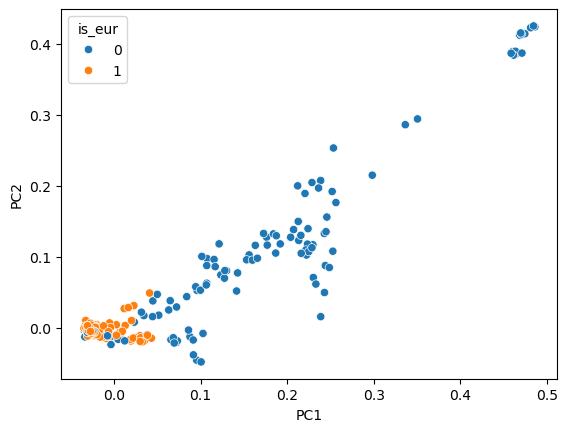

In [10]:
import seaborn as sb

plt.figure()
sb.scatterplot(data=df_pca_flt, x='PC1', y='PC2', hue='is_eur')
fig_name = 'PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

In [11]:
#########################################
# generate the big table
#file_name = 'combined_table.chr22.tsv'
#file_name = 'combined_table.tsv'
#df, biotypes = get_big_table(file_name)

# or read the big table
file_name = 'test.tsv'
df = pd.read_table(file_name, sep='\t', header=0)
#########################################

/tmp/ipykernel_372013/352308602.py:9: DtypeWarning: Columns (44,45,46,47,48,49,50,51,55,56,57,58,59,60,61,62,67,68,69,70,71,72,73,77,78,79,80,81,82,83,84,88,89,90,91,92,93,94,95,123,124,125,126,127,128,129,130,131,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(file_name, sep='\t', header=0)


hist_samples_genotyped.png


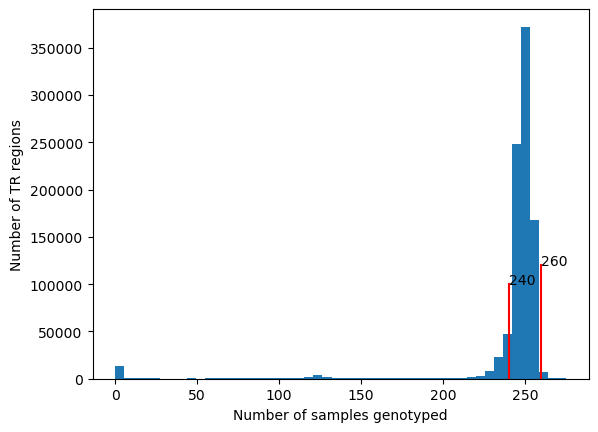

In [12]:
# plot histogram of the number of samples genotyped
plt.figure()
plt.hist(df.SN_GB, bins=50)
x_lim = 240
y_lim = 100000
plt.plot([x_lim, x_lim], [0, y_lim], '-r')
plt.text(x_lim, y_lim, f'{x_lim}')

x_lim = 260
y_lim = 120000
plt.plot([x_lim, x_lim], [0, y_lim], '-r')
plt.text(x_lim, y_lim, f'{x_lim}')

#plt.plot([60, 60], [0, 75000], '--r')
#plt.text(60, 75000, '60')
plt.xlabel('Number of samples genotyped')
plt.ylabel('Number of TR regions')
fig_name = 'hist_samples_genotyped.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

In [12]:
# filter out calls with low number of samples genotyped
df = df.loc[df.SN_GB >=200]
display(df)

,CHROM,POS,END,ID,GENCODE,ZS_SAMPLES,ZS_SAMPLES_NUM,SN_GB,DENOVO,DENOVO_GB,...,X_DEV_BR_GENE_20_intron,X_DEV_BR_GENE_30_cds,X_DEV_BR_GENE_30_utr,X_DEV_BR_GENE_30_intron,X_DEV_BR_GENE_40_cds,X_DEV_BR_GENE_40_utr,X_DEV_BR_GENE_40_intron,X_DEV_BR_GENE_50_cds,X_DEV_BR_GENE_50_utr,X_DEV_BR_GENE_50_intron
1,chr1,11196,11478,chr1_11195_11478,.,"REACH000001:-4.96|0.22:-40|0,REACH000402:-3.15...",13,221,.,.,...,0,0,0,0,0,0,0,0,0,0
2,chr1,15768,15879,chr1_15767_15879,exon,"REACH000099:0.09|3.30:0|5,REACH000380:-9.54|0....",11,250,.,.,...,0,0,0,0,0,0,0,0,0,0
3,chr1,16683,16774,chr1_16682_16774,exon,"REACH000183:-0.02|4.37:0|9,REACH000185:0.46|4....",17,255,.,.,...,0,0,0,0,0,0,0,0,0,0
4,chr1,19276,19473,chr1_19275_19473,.,"REACH000155:0.21|-5.81:0|-58,REACH000156:-5.81...",14,258,.,.,...,0,0,0,0,0,0,0,0,0,0
5,chr1,20799,20893,chr1_20798_20893,.,.,.,257,.,.,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909603,chrX,156019820,156020246,chrX_156019819_156020246,.,"REACH000479:-0.40|8.55:-12|205,REACH000480:-0....",2,236,.,.,...,0,0,0,0,0,0,0,0,0,0
909604,chrX,156020588,156020785,chrX_156020587_156020785,.,"REACH000404:-4.24|-0.16:-17|-1,REACH000417:-3....",11,240,.,.,...,0,0,0,0,0,0,0,0,0,0
909605,chrX,156023293,156023384,chrX_156023292_156023384,CDS,"REACH000645:0.09|3.59:0|9,REACH000410:-3.41|-0...",12,249,.,.,...,0,0,0,0,0,0,0,0,0,0
909606,chrX,156028581,156028780,chrX_156028580_156028780,.,REACH000702:-18.22|0.13:-94|0,1,253,.,.,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_insp = df.loc[(df.NUM_LZS9_SAMPLES > 0) & (df.X_DEV_BR_GENE_10_cds ==1)]
display(df_insp)


,CHROM,POS,END,ID,GENCODE,ZS_SAMPLES,ZS_SAMPLES_NUM,SN_GB,DENOVO,DENOVO_GB,...,X_DEV_BR_GENE_20_intron,X_DEV_BR_GENE_30_cds,X_DEV_BR_GENE_30_utr,X_DEV_BR_GENE_30_intron,X_DEV_BR_GENE_40_cds,X_DEV_BR_GENE_40_utr,X_DEV_BR_GENE_40_intron,X_DEV_BR_GENE_50_cds,X_DEV_BR_GENE_50_utr,X_DEV_BR_GENE_50_intron
315,chr1,1019786,1020230,chr1_1019785_1020230,start_codon,"REACH000705:0.20|3.15:-2|42,REACH000001:-3.08|...",9,247,.,.,...,0,0,0,0,0,0,0,0,0,0
464,chr1,1307610,1308243,chr1_1307609_1308243,start_codon,"REACH000401:-4.16|0.05:-77|-5,REACH000414:-12....",4,244,.,.,...,0,0,0,0,0,0,0,0,0,0
2450,chr1,6613760,6614091,chr1_6613759_6614091,start_codon,"REACH000417:-3.80|0.09:-34|-1,REACH000426:-4.3...",12,237,.,.,...,0,0,0,0,0,0,0,0,0,0
2466,chr1,6667703,6667785,chr1_6667702_6667785,CDS,REACH000410:0.27|9.97:-2|334,1,251,"REACH000501,REACH000681,REACH000685","-95|-1,-95|-2,0|-95",...,0,0,0,0,0,0,0,0,0,0
3064,chr1,8358169,8358292,chr1_8358168_8358292,CDS,"REACH000410:-4.22|-0.24:-20|-2,REACH000413:-0....",9,243,REACH000476,0|-35,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
909167,chrX,154367947,154368098,chrX_154367946_154368098,CDS,"REACH000418:0.15|-10.46:0|-62,REACH000420:0.15...",4,237,.,.,...,0,0,0,0,0,0,0,0,0,0
909197,chrX,154432004,154432315,chrX_154432003_154432315,CDS,"REACH000423:-10.58:-323,REACH000559:-10.58:-32...",3,241,REACH000681,-323,...,0,1,0,0,0,0,0,0,0,0
909200,chrX,154444124,154444261,chrX_154444123_154444261,start_codon,"REACH000381:0.13|-3.22:0|-22,REACH000401:0.13|...",18,233,REACH000581,-22|0,...,0,0,0,0,0,0,0,0,0,0
909209,chrX,154463500,154463603,chrX_154463499_154463603,CDS,"REACH000381:-4.98|0.09:-26|0,REACH000409:0.09|...",8,233,.,.,...,0,0,0,0,0,0,0,0,0,0


data_tables/table_lzs8_FDR_NDD_utr.tsv
df_flt shape: (384, 254)
507
240
len(samples_list): 747
len(samples_cases_list): 507
len(samples_controls_list): 240


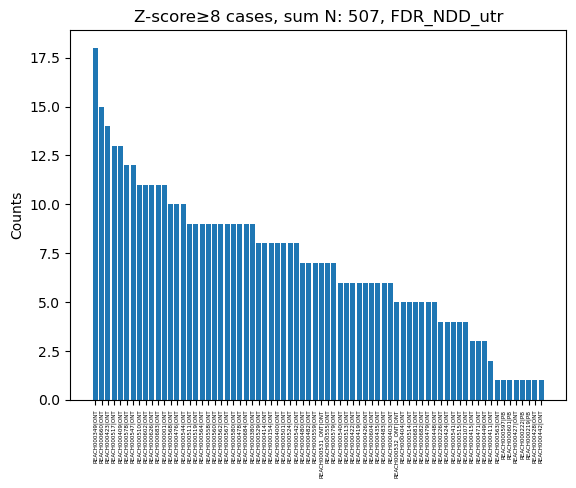

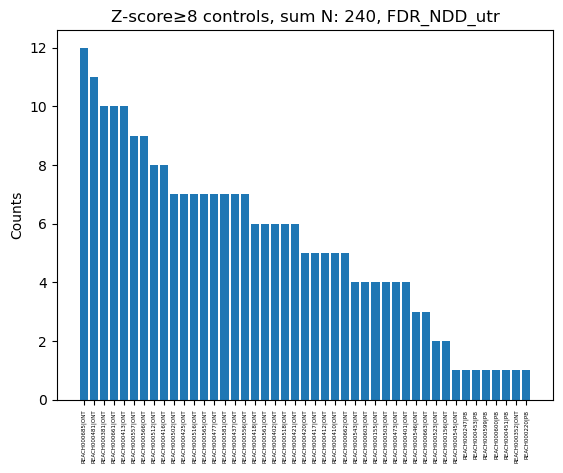

data_tables/table_lzs9_DEV_BR_GENE_10_cds.tsv
df_flt shape: (684, 254)
714
319
len(samples_list): 1033
len(samples_cases_list): 714
len(samples_controls_list): 319


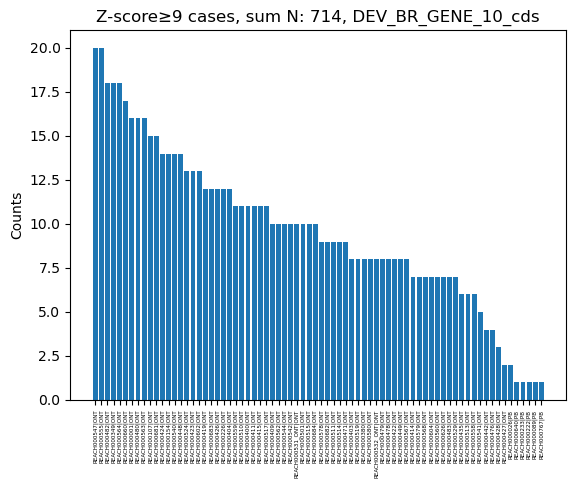

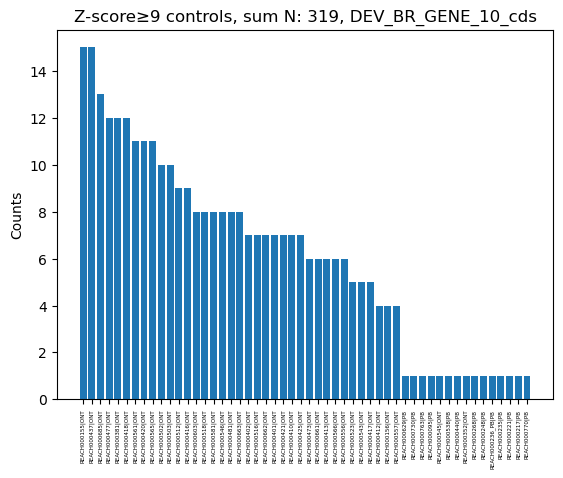

data_tables/table_lzs10_DEV_BR_GENE_10_cds.tsv
df_flt shape: (426, 254)
376
164
len(samples_list): 540
len(samples_cases_list): 376
len(samples_controls_list): 164


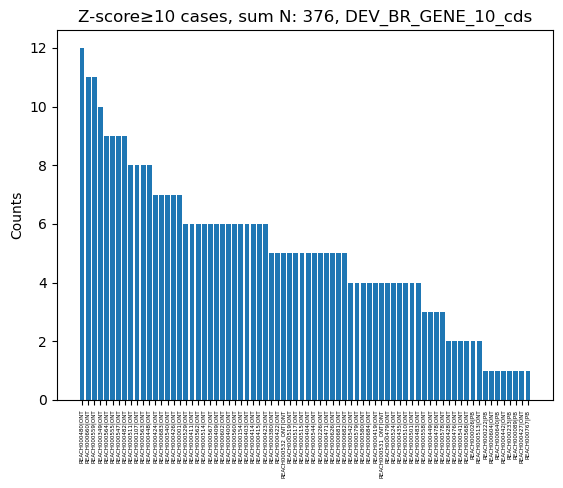

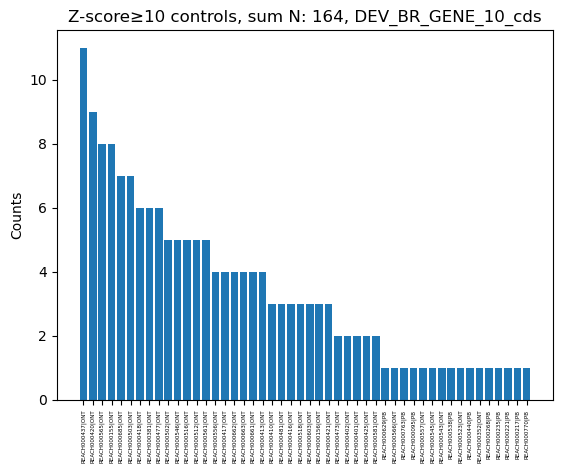

data_tables/table_lzs10_FDR_NDD_cds.tsv
df_flt shape: (102, 254)
95
33
len(samples_list): 128
len(samples_cases_list): 95
len(samples_controls_list): 33


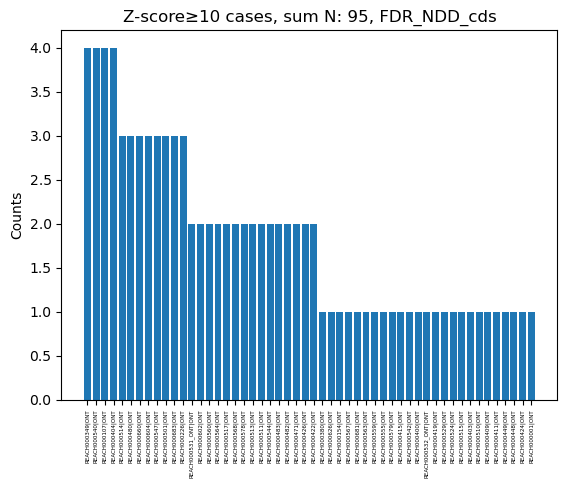

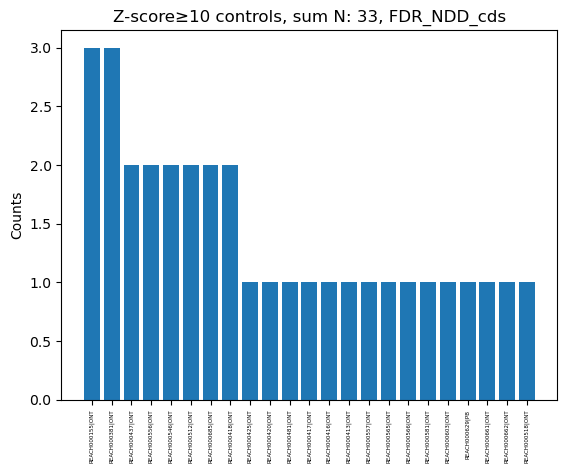

data_tables/table_lzs11_FDR_DD_cds.tsv
df_flt shape: (58, 254)
51
16
len(samples_list): 67
len(samples_cases_list): 51
len(samples_controls_list): 16


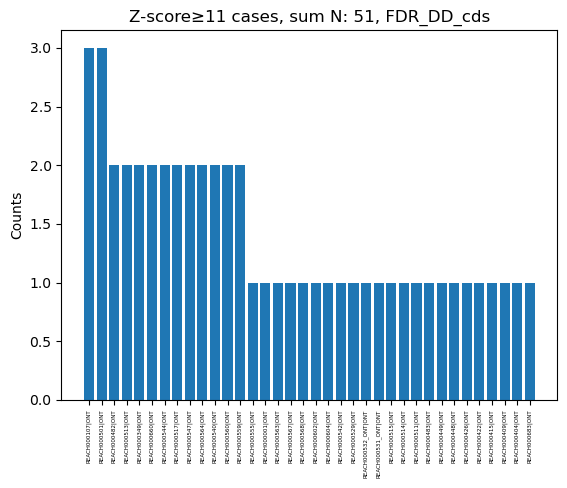

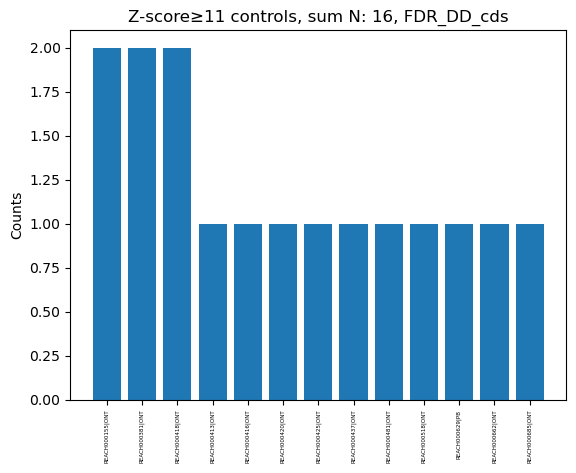

data_tables/table_lzs12_FDR_NDD_cds.tsv
df_flt shape: (47, 254)
41
11
len(samples_list): 52
len(samples_cases_list): 41
len(samples_controls_list): 11


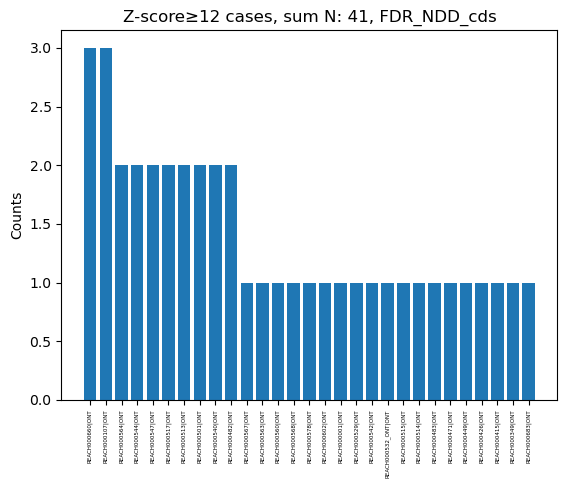

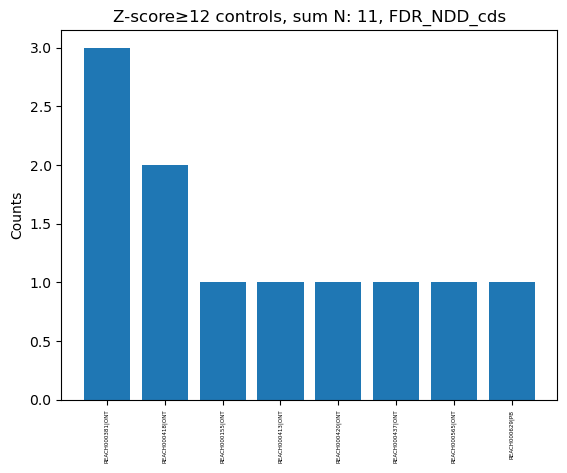

data_tables/table_lzs12_FDR_DD_cds.tsv
df_flt shape: (40, 254)
37
8
len(samples_list): 45
len(samples_cases_list): 37
len(samples_controls_list): 8


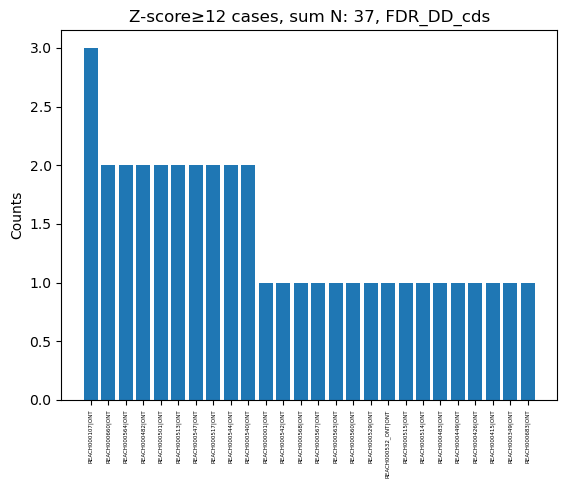

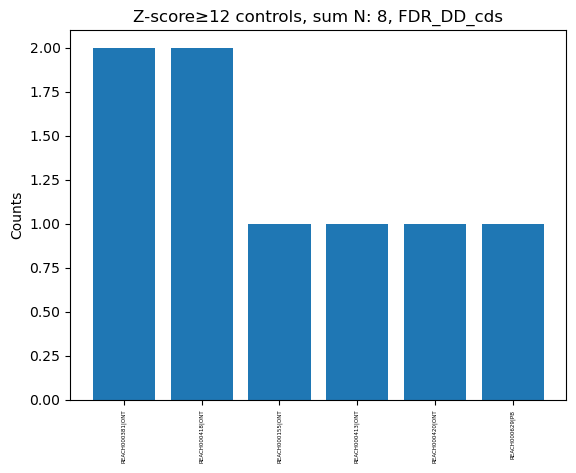

In [18]:
#df_flt = df.loc[(df['X_protein_coding_cds']==1) & (df['LZS9_SAMPLES']!='') & (df.SN_GB >=200)]
lzs_trgs = [8, 9, 10, 10, 11, 12, 12]
fts = ['FDR_NDD_utr', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_cds', 'FDR_NDD_cds', 'FDR_DD_cds', 'FDR_NDD_cds', 'FDR_DD_cds']
for lzs_trg, ft in zip(lzs_trgs, fts):
    flt_name = f'NUM_LZS{lzs_trg}_SAMPLES'
    df_flt = df.loc[(df[f'X_{ft}']==1) & (df[flt_name]>0) & (df.SN_GB >=200)]
    file_out = f'data_tables/table_lzs{lzs_trg}_{ft}.tsv'
    print(file_out)
    df_flt.to_csv(file_out, sep='\t', header=True, index=False)
    print(f'df_flt shape: {df_flt.shape}')
    print(df_flt[f'LZS{lzs_trg}_SAMPLES_CASE_NUM'].sum())
    print(df_flt[f'LZS{lzs_trg}_SAMPLES_CONTROL_NUM'].sum())
    samples_list = []
    samples_cases_list = []
    samples_controls_list = []
    for lzs, cases in zip(df_flt[f'LZS{lzs_trg}_SAMPLES'], df_flt[f'case_LZS{lzs_trg}_SAMPLES']) :
        samples = ['|'.join([x.split(':')[0], get_plat(x.split(':')[0])]) for x, y in zip(lzs.split(','), cases.split(','))]
        samples_cases = ['|'.join([x.split(':')[0], get_plat(x.split(':')[0])]) for x, y in zip(lzs.split(','), cases.split(',')) if y=='Yes']
        samples_controls = ['|'.join([x.split(':')[0], get_plat(x.split(':')[0])]) for x, y in zip(lzs.split(','), cases.split(',')) if y=='No']
        samples_list.extend(samples)
        samples_cases_list.extend(samples_cases)
        samples_controls_list.extend(samples_controls)
    print('len(samples_list):', len(samples_list))
    print('len(samples_cases_list):', len(samples_cases_list))
    print('len(samples_controls_list):', len(samples_controls_list))
    
    df_cases = pd.DataFrame({'samples': samples_cases_list})
    case_count_nums = df_cases.value_counts().tolist()
    case_count_samples = df_cases.value_counts().index.get_level_values(0).tolist()
    #print('count cases:')
    #print(case_count_nums)
    #print(case_count_samples)
    
    df_controls = pd.DataFrame({'samples': samples_controls_list})
    control_count_nums = df_controls.value_counts().tolist()
    control_count_samples = df_controls.value_counts().index.get_level_values(0).tolist()
    #print('count controls:')
    #print(control_count_nums)
    #print(control_count_samples)

    fig, ax = plt.subplots()
    ax.bar(case_count_samples, case_count_nums)
    ax.set_xticks(case_count_samples, case_count_samples, rotation=90, fontsize=4)
    ax.set_aspect('auto')
    plt.ylabel('Counts')
    plt.title(f'Z-score≥{lzs_trg} cases, sum N: {df_cases.shape[0]}, {ft}')
    fig_name = f'sample_case_lzs{lzs_trg}_{ft}'
    plt.savefig(fig_name+'.png', bbox_inches='tight')
    plt.savefig(fig_name+'.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

    fig, ax = plt.subplots()
    ax.bar(control_count_samples, control_count_nums)
    ax.set_xticks(control_count_samples, control_count_samples, rotation=90, fontsize=4)
    ax.set_aspect('auto')
    plt.ylabel('Counts')
    plt.title(f'Z-score≥{lzs_trg} controls, sum N: {df_controls.shape[0]}, {ft}')
    fig_name = f'sample_control_lzs{lzs_trg}_{ft}'
    plt.savefig(fig_name+'.png', bbox_inches='tight')
    plt.savefig(fig_name+'.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

hist_zscore.png


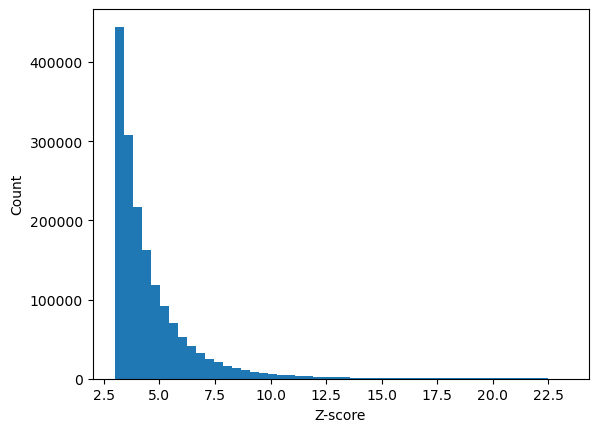

hist_bp_dev_lzs10.png


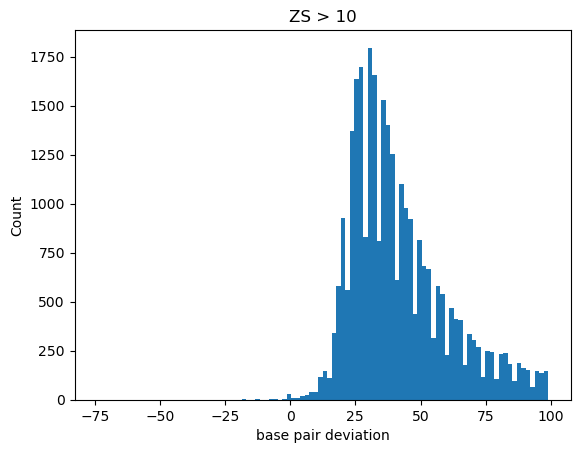

hist_bp_dev_lzs9.png


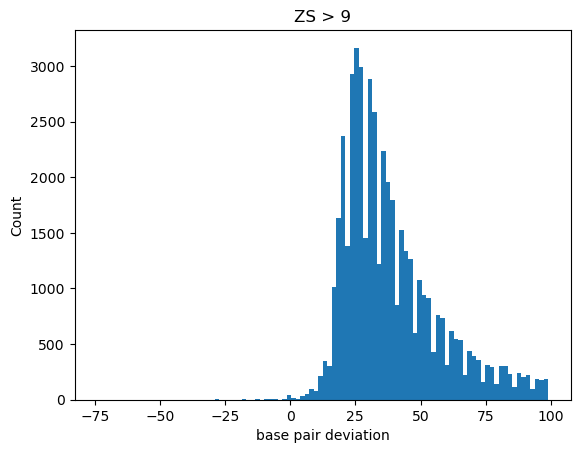

hist_bp_dev_lzs5.png


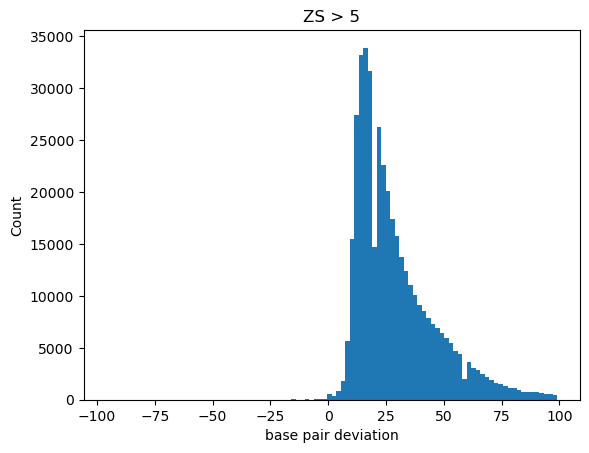

hist_bp_dev_lzs3.png


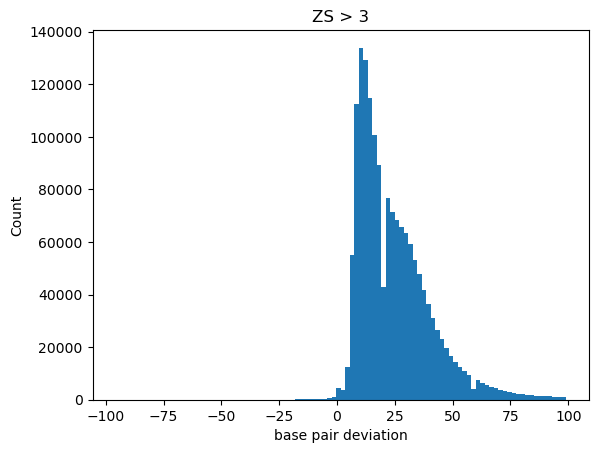

In [66]:
file_name = 'zs_large_3.txt'
df_zs = pd.read_table(file_name, sep='\t', names=['ID', 'Z-score', 'GB'])
#print(df_zs)
plt.figure()
plt.hist(df_zs['Z-score'], bins=50)
plt.xlabel('Z-score')
plt.ylabel('Count')
fig_name = 'hist_zscore.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

for z_thr in [10, 9, 5, 3]:
    plt.figure()
    bp_thr = 100
    plt.hist(df_zs.loc[(df_zs['Z-score'].abs()>z_thr) & (df_zs.GB.abs()<bp_thr)]['GB'], bins=100)
    plt.xlabel('base pair deviation')
    plt.ylabel('Count')
    plt.title(f'ZS > {z_thr}')
    fig_name = f'hist_bp_dev_lzs{z_thr}.png'
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

In [14]:
biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
pc_subsec = ['protein_coding_cds', 'protein_coding_utr', 'protein_coding_intron', 
             'protein_coding_cds_pli', 'protein_coding_cds_loeuf', 
             'protein_coding_cds_fdr_asd', 'protein_coding_cds_fdr_dd', 'protein_coding_cds_fdr_ndd']
consts_1 = ['PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD']
consts_2 = ['FB_PR', 'FB_ENH', 'FANTOM', 'GNOCCHI_1', 'GNOCCHI_2', 'GNOCCHI_3', 'GNOCCHI_4']
consts_subsec_1 = ['PLI_cds', 'PLI_utr', 'PLI_intron', 
                   'LOEUF_cds', 'LOEUF_utr', 'LOEUF_intron']
consts_subsec_2 = ['FDR_ASD_cds', 'FDR_ASD_utr', 'FDR_ASD_intron', 
                   'FDR_DD_cds', 'FDR_DD_utr', 'FDR_DD_intron', 
                   'FDR_NDD_cds', 'FDR_NDD_utr', 'FDR_NDD_intron']
consts_subsec_3 = ['PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron',
                   'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron']
dev_br_10 = ['DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron']
dev_br_20 = ['DEV_BR_GENE_20', 'DEV_BR_GENE_20_cds', 'DEV_BR_GENE_20_utr', 'DEV_BR_GENE_20_intron']
dev_br_30 = ['DEV_BR_GENE_30', 'DEV_BR_GENE_30_cds', 'DEV_BR_GENE_30_utr', 'DEV_BR_GENE_30_intron']
dev_br_40 = ['DEV_BR_GENE_40', 'DEV_BR_GENE_40_cds', 'DEV_BR_GENE_40_utr', 'DEV_BR_GENE_40_intron']
dev_br_50 = ['DEV_BR_GENE_50', 'DEV_BR_GENE_50_cds', 'DEV_BR_GENE_50_utr', 'DEV_BR_GENE_50_intron']

In [16]:
#fts = (biotypes + pc_subsec + consts_1 + consts_2 + consts_subsec_1 + consts_subsec_2 + consts_subsec_3 +
#       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50)
fts = (consts_1 + consts_2 + consts_subsec_1 + consts_subsec_2 + consts_subsec_3 +
       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50)

df_main = pd.DataFrame(df_pca_flt)
#samples_col = 'LZS9_SAMPLES'
for ft in fts:
    print(ft)
    this_df = df.loc[df[f'X_{ft}'] == 1]
    for zs_thr in lzs_thrs:
        samples_col = f'LZS{zs_thr}_SAMPLES'
        temp = this_df[samples_col].str.split(',').tolist()
        this_samples_list = []
        for x in temp:
            this_samples_list.extend([xx.split(':')[0] for xx in x])
        count_col = []
        for sample in df_pca_flt.iid.tolist():
            count_col.append(this_samples_list.count(sample))
        df_main[f'count_ZS{zs_thr}_{ft}'] = count_col

display(df_main)
#file_out = 'main_df_toR_lzs_9_10_11_12.csv'
#file_out = 'main_df_toR_lzs_5_7_9_10_11_12_14_16_18_20.csv'
file_out = 'main_df_toR_lzs_7_8_9_10_11_12_13_14.csv'
print(f'writing {file_out}')
df_main.to_csv(file_out, sep=',', header=True, index=False)

PLI
LOEUF
FDR_ASD
FDR_DD
FDR_NDD
FB_PR
FB_ENH
FANTOM
GNOCCHI_1
GNOCCHI_2
GNOCCHI_3
GNOCCHI_4


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

PLI_cds
PLI_utr


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

PLI_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

LOEUF_cds
LOEUF_utr


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

LOEUF_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

FDR_ASD_cds
FDR_ASD_utr
FDR_ASD_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

FDR_DD_cds
FDR_DD_utr
FDR_DD_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

FDR_NDD_cds
FDR_NDD_utr
FDR_NDD_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

PLIp9_cds


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

PLIp9_utr


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

PLIp9_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

LOWPLI_cds


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

LOWPLI_utr


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

LOWPLI_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_10


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_10_cds
DEV_BR_GENE_10_utr


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_10_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_20


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_20_cds
DEV_BR_GENE_20_utr
DEV_BR_GENE_20_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_30


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_30_cds
DEV_BR_GENE_30_utr
DEV_BR_GENE_30_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_40


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_40_cds
DEV_BR_GENE_40_utr
DEV_BR_GENE_40_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_50


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

DEV_BR_GENE_50_cds
DEV_BR_GENE_50_utr
DEV_BR_GENE_50_intron


/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_ZS{zs_thr}_{ft}'] = count_col
/tmp/ipykernel_147222/3080825781.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,count_ZS13_DEV_BR_GENE_50_utr,count_ZS14_DEV_BR_GENE_50_utr,count_ZS7_DEV_BR_GENE_50_intron,count_ZS8_DEV_BR_GENE_50_intron,count_ZS9_DEV_BR_GENE_50_intron,count_ZS10_DEV_BR_GENE_50_intron,count_ZS11_DEV_BR_GENE_50_intron,count_ZS12_DEV_BR_GENE_50_intron,count_ZS13_DEV_BR_GENE_50_intron,count_ZS14_DEV_BR_GENE_50_intron
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0,0,95,56,26,16,6,4,3,2
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,0,0,1,1,1,0,0,0,0,0
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,0,0,0,0,0,0,0,0,0,0
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0,0,0,0,0,0,0,0,0,0
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,0,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,0,0,0,0,0,0,0,0,0,0
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,0,0,0,0,0,0,0,0,0,0
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,0,0,0,0,0,0,0,0,0,0
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,0,0,0,0,0,0,0,0,0,0


writing main_df_toR_lzs_7_8_9_10_11_12_13_14.csv


In [15]:
def plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.02, dx2=0.02):
    # plot enrichment in biotypes
    ORs = []
    text_info = []
    chisq_ps = []
    for ft in fts:
        df_w = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        df_wo = df_flt.loc[df_flt[f'X_{ft}'] == 0]
        print(f'regions intersecting {ft}: {df_w.shape[0]}')
        
        n_w_ft_case = df_w[f'{flt_name}_CASE_NUM'].sum()
        n_w_ft_control = df_w[f'{flt_name}_CONTROL_NUM'].sum()
        n_wo_ft_case = df_wo[f'{flt_name}_CASE_NUM'].sum()
        n_wo_ft_control = df_wo[f'{flt_name}_CONTROL_NUM'].sum()
        text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
        
        OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
        #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')#print(f'OR: {OR}')
        ORs.append(OR)
        ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
        try:
            chi2_stat, p_val, dof, expected = chi2_contingency(ob)
        except:
            p_val = np.nan
        chisq_ps.append(p_val)
        
    print('case/control chi-squared p-values:')
    print(' '.join(fts))
    print(' '.join([f'{x:.2e}' for x in chisq_ps]))
    #AR = 5
    plt.figure()
    plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
    for i in range(0,len(fts)):
        plt.text(i, ORs[i]+dx1, text_info[i], rotation=15, fontsize=8)
        plt.text(i, ORs[i]-dx2, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
    plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
    plt.gca().set_aspect(AR)
    plt.ylabel('Odds ratio')
    plt.title('numbers: # cases / # controls, xing features')
    #plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

regions intersecting lncRNA: 154938
regions intersecting miRNA: 141
regions intersecting misc_RNA: 363
regions intersecting processed_transcript: 2884
regions intersecting snoRNA: 77
regions intersecting snRNA: 206
regions intersecting TEC: 569
regions intersecting protein_coding: 384002
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
2.69e-01 3.69e-02 6.79e-01 4.10e-01 4.71e-01 5.55e-01 1.69e-01 3.79e-02
odds_ratio_biotypes.png


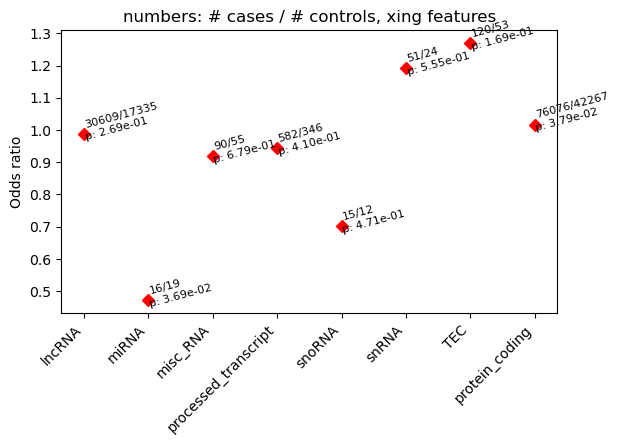

In [16]:
# plot enrichment in biotypes
fts = biotypes
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_biotypes.png'
plot_enrich(df, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

regions intersecting protein_coding_cds: 15384
regions intersecting protein_coding_utr: 17098
regions intersecting protein_coding_intron: 351520
regions intersecting protein_coding_cds_pli: 4096
regions intersecting protein_coding_cds_loeuf: 2997
regions intersecting protein_coding_cds_fdr_asd: 372
regions intersecting protein_coding_cds_fdr_dd: 861
regions intersecting protein_coding_cds_fdr_ndd: 1162
case/control chi-squared p-values:
protein_coding_cds protein_coding_utr protein_coding_intron protein_coding_cds_pli protein_coding_cds_loeuf protein_coding_cds_fdr_asd protein_coding_cds_fdr_dd protein_coding_cds_fdr_ndd
7.87e-02 4.25e-01 6.15e-02 2.71e-01 1.55e-01 1.19e-01 2.72e-02 1.54e-02
odds_ratio_pc_subsec.png


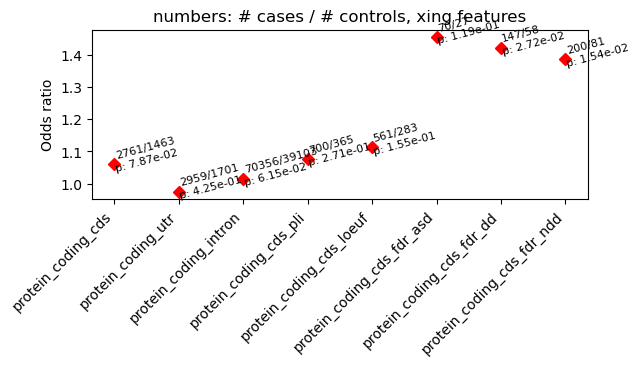

In [17]:
# plot enrichment in protein coding subsections
fts = pc_subsec
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_pc_subsec.png'
plot_enrich(df, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

regions intersecting PLI: 125270
regions intersecting LOEUF: 89543
regions intersecting FDR_ASD: 11051
regions intersecting FDR_DD: 22842
regions intersecting FDR_NDD: 31522
case/control chi-squared p-values:
PLI LOEUF FDR_ASD FDR_DD FDR_NDD
1.38e-01 2.99e-01 6.76e-01 3.58e-01 5.63e-02
odds_ratio_constrains_coding.png


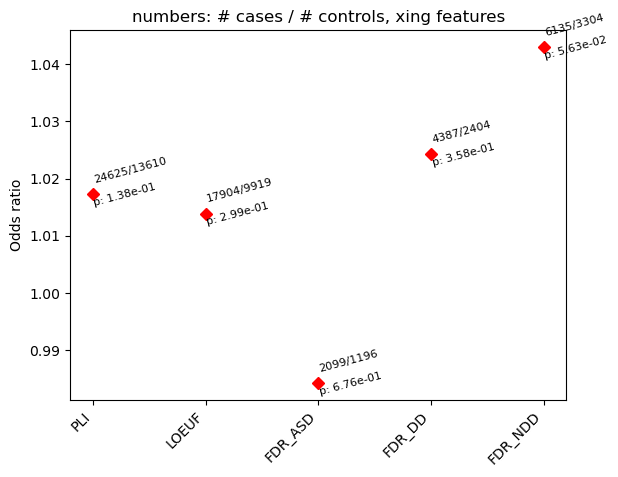

In [18]:
# plot enrichment in coding constrains
fts = consts_1
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_constrains_coding.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.002, dx2=0.002)

regions intersecting FB_PR: 25283
regions intersecting FB_ENH: 51385
regions intersecting FANTOM: 10797
regions intersecting GNOCCHI_1: 194541
regions intersecting GNOCCHI_2: 90274
regions intersecting GNOCCHI_3: 33697
regions intersecting GNOCCHI_4: 11709
case/control chi-squared p-values:
FB_PR FB_ENH FANTOM GNOCCHI_1 GNOCCHI_2 GNOCCHI_3 GNOCCHI_4
2.90e-03 1.56e-03 1.55e-01 1.20e-03 1.45e-02 4.13e-02 7.11e-03
odds_ratio_constrains_noncoding.png


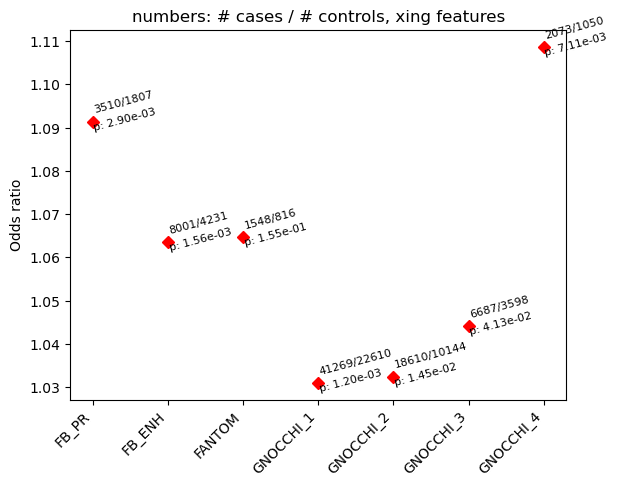

In [19]:
# plot enrichment in non-coding constrains
fts = consts_2
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_constrains_noncoding.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.002, dx2=0.002)

regions intersecting PLI_cds: 4096
regions intersecting PLI_utr: 4997
regions intersecting PLI_intron: 116177
regions intersecting LOEUF_cds: 2997
regions intersecting LOEUF_utr: 3822
regions intersecting LOEUF_intron: 82724
case/control chi-squared p-values:
PLI_cds PLI_utr PLI_intron LOEUF_cds LOEUF_utr LOEUF_intron
2.71e-01 9.43e-01 1.81e-01 1.55e-01 8.18e-01 4.59e-01
odds_ratio_pli_loeuf_subset.png


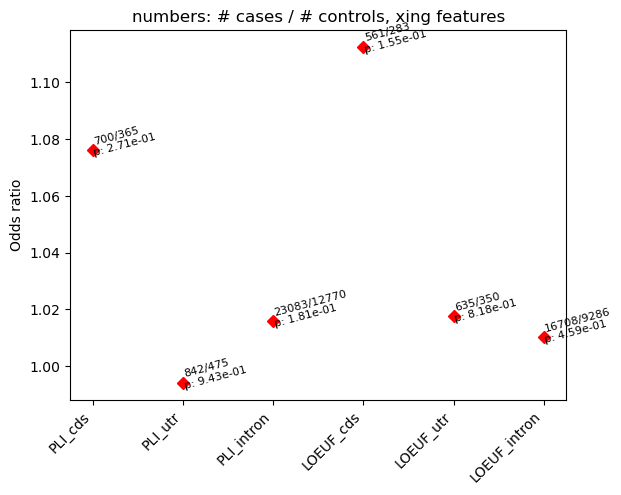

In [20]:
# plot enrichment in constrained subsets
fts = consts_subsec_1
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_pli_loeuf_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.002, dx2=0.002)

regions intersecting FDR_ASD_cds: 372
regions intersecting FDR_ASD_utr: 470
regions intersecting FDR_ASD_intron: 10209
regions intersecting FDR_DD_cds: 861
regions intersecting FDR_DD_utr: 1106
regions intersecting FDR_DD_intron: 20875
regions intersecting FDR_NDD_cds: 1162
regions intersecting FDR_NDD_utr: 1409
regions intersecting FDR_NDD_intron: 28951
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
1.19e-01 9.04e-01 4.93e-01 2.72e-02 4.19e-01 7.16e-01 1.54e-02 3.88e-01 1.79e-01
odds_ratio_fdr_subset.png


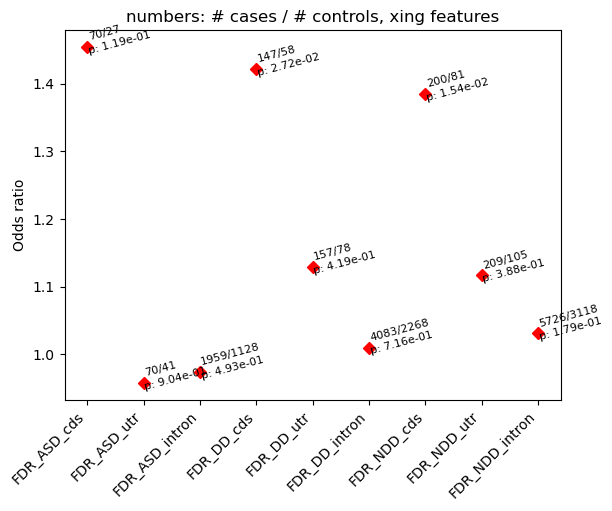

In [21]:
# plot enrichment in constrained subsets
fts = consts_subsec_2
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_fdr_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.01, dx2=0.01)

regions intersecting PLIp9_cds: 4845
regions intersecting PLIp9_utr: 6203
regions intersecting PLIp9_intron: 137596
regions intersecting LOWPLI_cds: 10365
regions intersecting LOWPLI_utr: 10883
regions intersecting LOWPLI_intron: 211830
case/control chi-squared p-values:
PLIp9_cds PLIp9_utr PLIp9_intron LOWPLI_cds LOWPLI_utr LOWPLI_intron
4.88e-01 7.36e-01 1.80e-01 1.32e-01 3.07e-01 3.59e-01
odds_ratio_pli2_subset.png


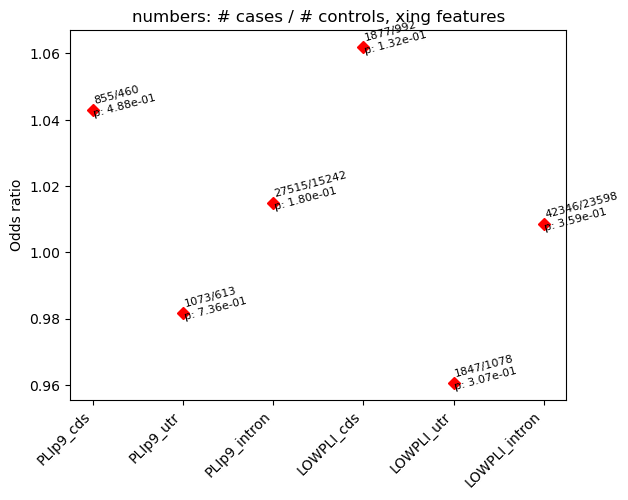

In [22]:
# plot enrichment in constrained subsets
fts = consts_subsec_3
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_pli2_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.002, dx2=0.002)

regions intersecting DEV_BR_GENE_10: 85181
regions intersecting DEV_BR_GENE_10_cds: 3761
regions intersecting DEV_BR_GENE_10_utr: 4442
regions intersecting DEV_BR_GENE_10_intron: 76978
case/control chi-squared p-values:
DEV_BR_GENE_10 DEV_BR_GENE_10_cds DEV_BR_GENE_10_utr DEV_BR_GENE_10_intron
1.05e-02 7.81e-04 6.09e-01 7.13e-02
odds_ratio_dev_br10_subset.png


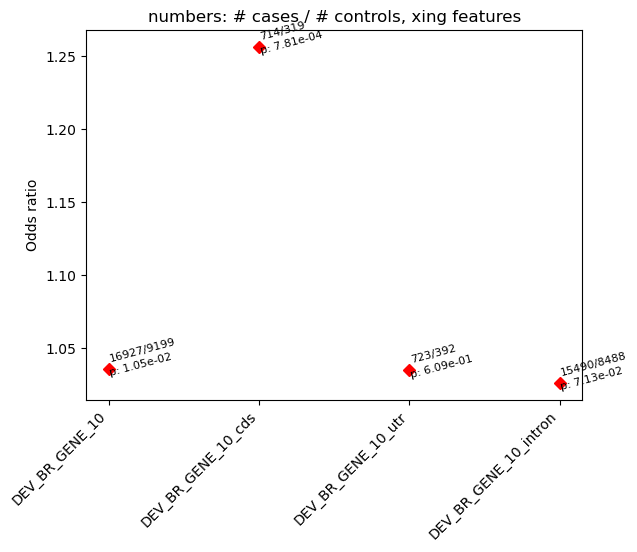

In [23]:
# plot enrichment in dev brain subsets 10
fts = dev_br_10
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_dev_br10_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.005, dx2=0.005)

regions intersecting DEV_BR_GENE_20: 38288
regions intersecting DEV_BR_GENE_20_cds: 1805
regions intersecting DEV_BR_GENE_20_utr: 2171
regions intersecting DEV_BR_GENE_20_intron: 34312
case/control chi-squared p-values:
DEV_BR_GENE_20 DEV_BR_GENE_20_cds DEV_BR_GENE_20_utr DEV_BR_GENE_20_intron
1.26e-01 8.24e-03 4.41e-01 3.95e-01
odds_ratio_dev_br20_subset.png


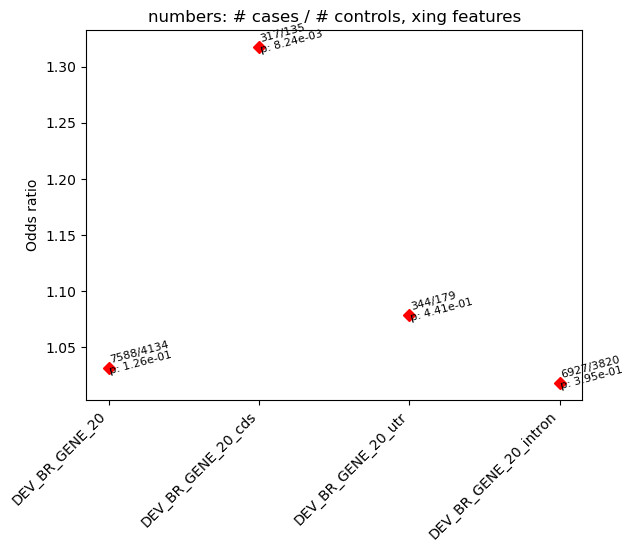

In [24]:
# plot enrichment in dev brain subsets 20
fts = dev_br_20
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_dev_br20_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.005, dx2=0.005)

regions intersecting DEV_BR_GENE_30: 19296
regions intersecting DEV_BR_GENE_30_cds: 1095
regions intersecting DEV_BR_GENE_30_utr: 1326
regions intersecting DEV_BR_GENE_30_intron: 16875
case/control chi-squared p-values:
DEV_BR_GENE_30 DEV_BR_GENE_30_cds DEV_BR_GENE_30_utr DEV_BR_GENE_30_intron
1.17e-01 7.87e-02 1.00e+00 2.18e-01
odds_ratio_dev_br30_subset.png


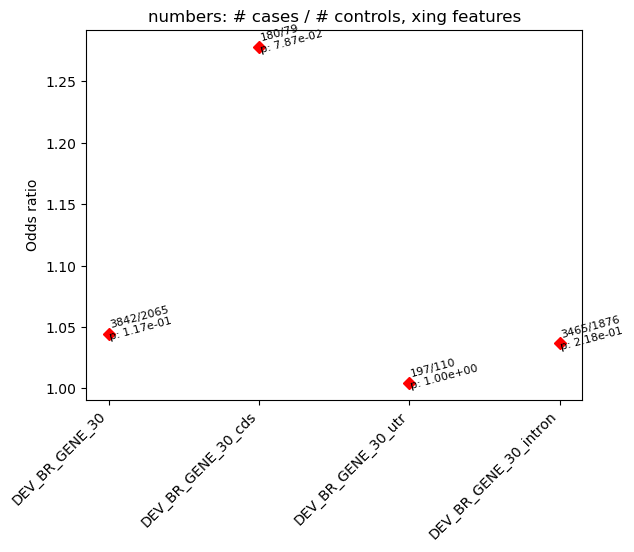

In [25]:
# plot enrichment in dev brain subsets 30
fts = dev_br_30
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_dev_br30_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.005, dx2=0.005)

regions intersecting DEV_BR_GENE_40: 11203
regions intersecting DEV_BR_GENE_40_cds: 697
regions intersecting DEV_BR_GENE_40_utr: 865
regions intersecting DEV_BR_GENE_40_intron: 9641
case/control chi-squared p-values:
DEV_BR_GENE_40 DEV_BR_GENE_40_cds DEV_BR_GENE_40_utr DEV_BR_GENE_40_intron
5.20e-01 7.06e-01 2.46e-01 3.71e-01
odds_ratio_dev_br40_subset.png


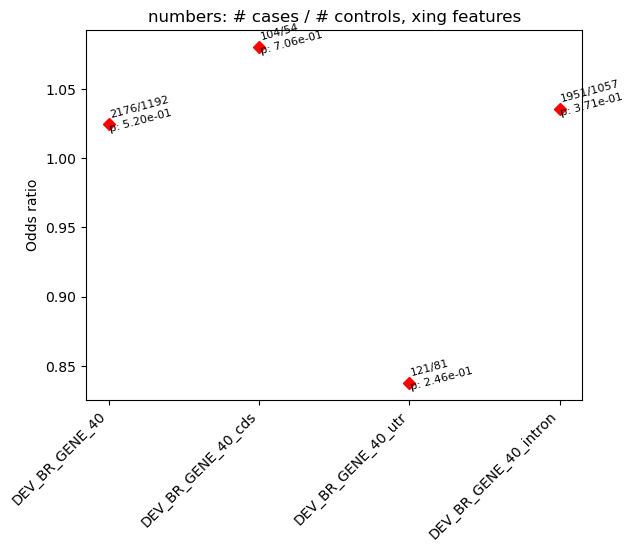

In [26]:
# plot enrichment in dev brain subsets 40
fts = dev_br_40
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_dev_br40_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.005, dx2=0.005)

regions intersecting DEV_BR_GENE_50: 7847
regions intersecting DEV_BR_GENE_50_cds: 513
regions intersecting DEV_BR_GENE_50_utr: 615
regions intersecting DEV_BR_GENE_50_intron: 6719
case/control chi-squared p-values:
DEV_BR_GENE_50 DEV_BR_GENE_50_cds DEV_BR_GENE_50_utr DEV_BR_GENE_50_intron
1.70e-01 6.45e-01 8.72e-01 1.67e-01
odds_ratio_dev_br50_subset.png


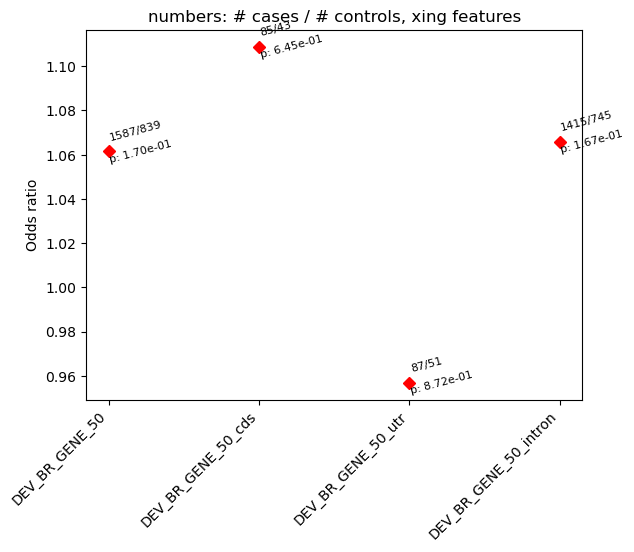

In [27]:
# plot enrichment in dev brain subsets 50
fts = dev_br_50
flt_name = 'LZS9_SAMPLES'
fig_name = 'odds_ratio_dev_br50_subset.png'
plot_enrich(df, fts, flt_name, fig_name, AR='auto', dx1=0.005, dx2=0.005)

TR regions intersecting lncRNA: 143876
TR regions intersecting miRNA: 124
TR regions intersecting misc_RNA: 333
TR regions intersecting processed_transcript: 2611
TR regions intersecting snoRNA: 67
TR regions intersecting snRNA: 190
TR regions intersecting TEC: 545
TR regions intersecting protein_coding: 354086
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
6.56e-01 7.21e-01 4.06e-01 4.97e-01 1.47e-01 1.00e+00 1.77e-01 6.54e-01

case/control chi-squared p-values high coverage samples:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
8.78e-01 1.66e-01 4.51e-01 7.18e-01 6.64e-01 9.17e-01 5.95e-01 5.18e-01
odds_ratio_biotypes.png


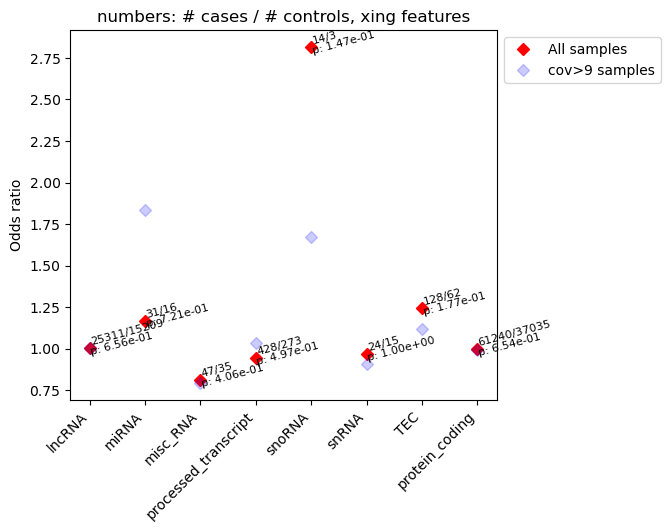

In [17]:
# plot enrichment in biotypes
fts = biotypes
fig_name = 'odds_ratio_biotypes.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS_CASE_COV_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS_CONTROL_COV_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS_CASE_COV_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS_CONTROL_COV_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 3
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.02, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.04, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


TR regions intersecting DEV_BR_GENE_10: 85181
TR regions intersecting DEV_BR_GENE_10_cds: 3761
TR regions intersecting DEV_BR_GENE_10_utr: 4442
TR regions intersecting DEV_BR_GENE_10_intron: 76978
case/control chi-squared p-values:
DEV_BR_GENE_10 DEV_BR_GENE_10_cds DEV_BR_GENE_10_utr DEV_BR_GENE_10_intron
1.05e-02 7.81e-04 6.09e-01 7.13e-02

case/control chi-squared p-values high coverage samples:
DEV_BR_GENE_10 DEV_BR_GENE_10_cds DEV_BR_GENE_10_utr DEV_BR_GENE_10_intron
3.73e-02 7.57e-03 7.87e-01 1.30e-01
odds_ratio_dev_br.png


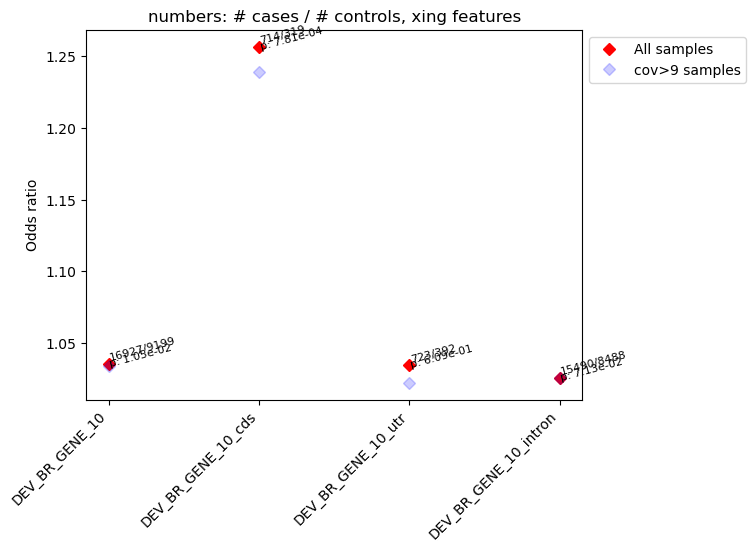

In [19]:
# plot enrichment in biotypes
fts = dev_br
fig_name = 'odds_ratio_dev_br.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS9_SAMPLES_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS9_SAMPLES_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS9_SAMPLES_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS9_SAMPLES_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS9_SAMPLES_COV_CASE_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS9_SAMPLES_COV_CONTROL_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS9_SAMPLES_COV_CASE_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS9_SAMPLES_COV_CONTROL_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 'auto'
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.002, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.002, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


TR regions intersecting DEV_BR_GENE: 35818
TR regions intersecting DEV_BR_GENE_cds: 1664
TR regions intersecting DEV_BR_GENE_utr: 2018
TR regions intersecting DEV_BR_GENE_intron: 32136
case/control chi-squared p-values:
DEV_BR_GENE DEV_BR_GENE_cds DEV_BR_GENE_utr DEV_BR_GENE_intron
1.35e-01 6.38e-01 6.45e-01 1.09e-01

case/control chi-squared p-values high coverage samples:
DEV_BR_GENE DEV_BR_GENE_cds DEV_BR_GENE_utr DEV_BR_GENE_intron
6.77e-02 8.86e-01 8.28e-01 6.82e-02
odds_ratio_dev_br.png


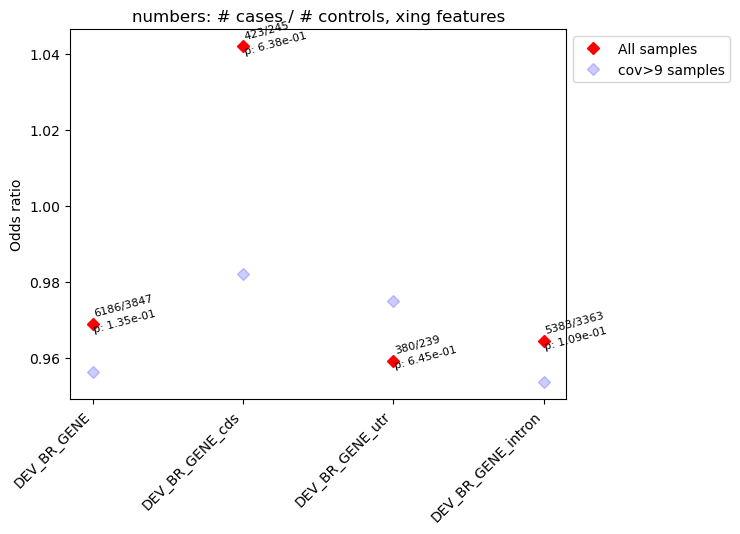

In [16]:
# plot enrichment in biotypes
fts = dev_br
fig_name = 'odds_ratio_dev_br.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS9_SAMPLES_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS_CASE_COV_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS_CONTROL_COV_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS_CASE_COV_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS_CONTROL_COV_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 'auto'
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.002, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.002, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


TR regions intersecting protein_coding_cds: 14130
TR regions intersecting protein_coding_utr: 15606
TR regions intersecting protein_coding_intron: 324350
TR regions intersecting protein_coding_cds_pli: 3656
TR regions intersecting protein_coding_cds_loeuf: 9830
TR regions intersecting protein_coding_cds_fdr_asd: 359
TR regions intersecting protein_coding_cds_fdr_dd: 815
TR regions intersecting protein_coding_cds_fdr_ndd: 1097
case/control chi-squared p-values:
protein_coding_cds protein_coding_utr protein_coding_intron protein_coding_cds_pli protein_coding_cds_loeuf protein_coding_cds_fdr_asd protein_coding_cds_fdr_dd protein_coding_cds_fdr_ndd
5.84e-01 3.47e-01 3.60e-01 4.67e-01 8.77e-01 4.19e-01 1.18e-01 8.41e-02

case/control chi-squared p-values high coverage samples:
protein_coding_cds protein_coding_utr protein_coding_intron protein_coding_cds_pli protein_coding_cds_loeuf protein_coding_cds_fdr_asd protein_coding_cds_fdr_dd protein_coding_cds_fdr_ndd
9.17e-01 3.91e-01 3.41e-01 6.

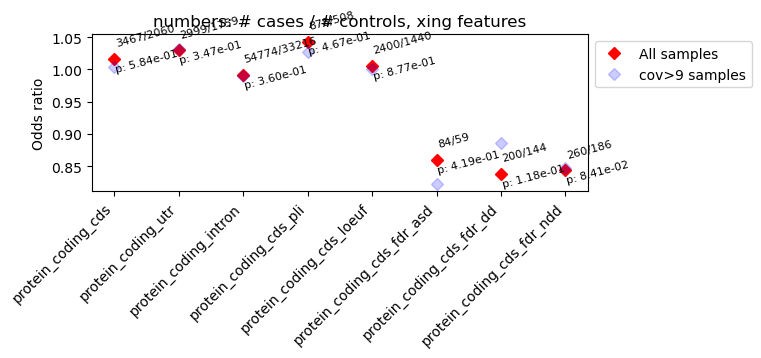

In [18]:
# plot enrichment in protein coding subsections
fts = pc_subsec
fig_name = 'odds_ratio_pc_subsec.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS_CASE_COV_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS_CONTROL_COV_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS_CASE_COV_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS_CONTROL_COV_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 10
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.02, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.02, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


TR regions intersecting PLI: 113262
TR regions intersecting LOEUF: 276261
TR regions intersecting FDR_ASD: 10622
TR regions intersecting FDR_DD: 21779
TR regions intersecting FDR_NDD: 30136
case/control chi-squared p-values:
PLI LOEUF FDR_ASD FDR_DD FDR_NDD
2.21e-01 2.69e-01 8.01e-01 1.27e-01 3.56e-02

case/control chi-squared p-values high coverage samples:
PLI LOEUF FDR_ASD FDR_DD FDR_NDD
3.68e-01 4.35e-01 6.36e-01 1.90e-01 6.22e-02
odds_ratio_constrains_1.png


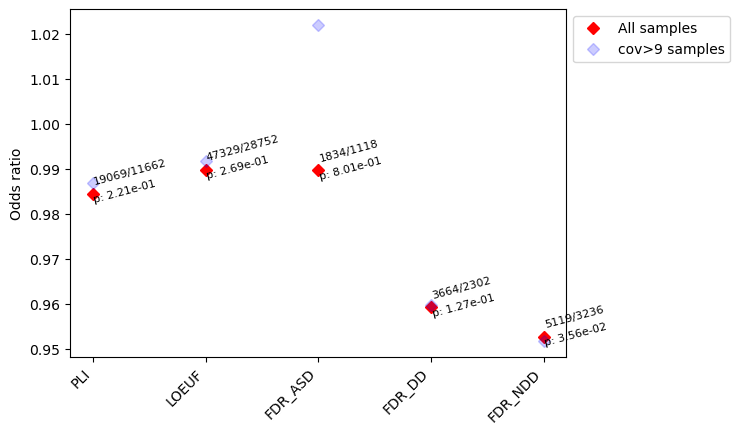

In [19]:
# plot enrichment in constrained annotations
fts = consts_1
fig_name = 'odds_ratio_constrains_1.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS_CASE_COV_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS_CONTROL_COV_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS_CASE_COV_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS_CONTROL_COV_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 40
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.002, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.002, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
#plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


TR regions intersecting FB_PR: 22765
TR regions intersecting FB_ENH: 49071
TR regions intersecting FANTOM: 10133
TR regions intersecting GNOCCHI_1: 189638
TR regions intersecting GNOCCHI_2: 88219
TR regions intersecting GNOCCHI_3: 32965
TR regions intersecting GNOCCHI_4: 11439
case/control chi-squared p-values:
FB_PR FB_ENH FANTOM GNOCCHI_1 GNOCCHI_2 GNOCCHI_3 GNOCCHI_4
1.76e-02 3.56e-03 4.06e-01 7.69e-05 3.54e-05 9.51e-04 3.57e-03

case/control chi-squared p-values high coverage samples:
FB_PR FB_ENH FANTOM GNOCCHI_1 GNOCCHI_2 GNOCCHI_3 GNOCCHI_4
3.19e-02 5.32e-02 4.56e-01 8.18e-02 1.90e-02 4.40e-01 1.96e-01
odds_ratio_constrains_2.png


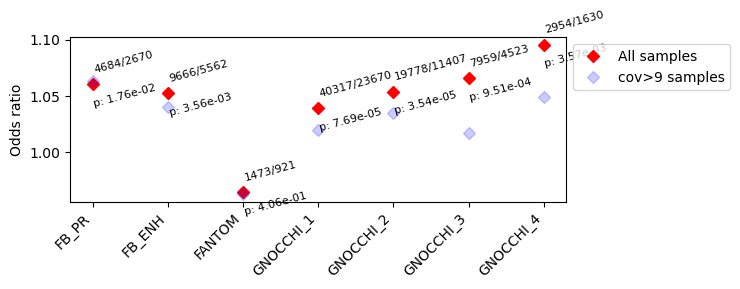

In [20]:
# plot enrichment in constrained annotations
fts = consts_2
fig_name = 'odds_ratio_constrains_2.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS_CASE_COV_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS_CONTROL_COV_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS_CASE_COV_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS_CONTROL_COV_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 15
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.01, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.02, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
#plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


TR regions intersecting PLI_cds: 3656
TR regions intersecting PLI_utr: 4501
TR regions intersecting PLI_intron: 105105
TR regions intersecting LOEUF_cds: 9843
TR regions intersecting LOEUF_utr: 11223
TR regions intersecting LOEUF_intron: 255195
case/control chi-squared p-values:
PLI_cds PLI_utr PLI_intron LOEUF_cds LOEUF_utr LOEUF_intron
4.67e-01 3.96e-01 2.11e-01 8.54e-01 3.16e-01 1.43e-01

case/control chi-squared p-values high coverage samples:
PLI_cds PLI_utr PLI_intron LOEUF_cds LOEUF_utr LOEUF_intron
6.97e-01 7.17e-01 3.46e-01 9.87e-01 2.67e-01 2.67e-01
odds_ratio_pli_loeuf_subset.png


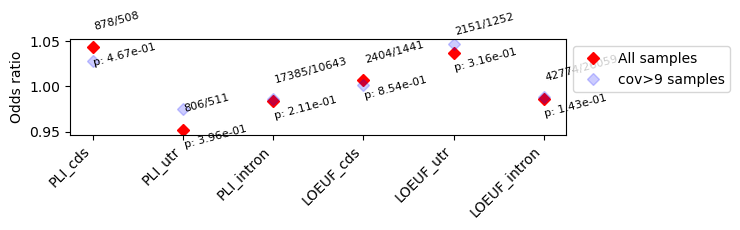

In [21]:
# plot enrichment in constrained subsets
fts = consts_subsec_1
fig_name = 'odds_ratio_pli_loeuf_subset.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS_CASE_COV_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS_CONTROL_COV_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS_CASE_COV_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS_CONTROL_COV_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 10
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.02, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.02, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
#plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


TR regions intersecting FDR_ASD_cds: 359
TR regions intersecting FDR_ASD_utr: 442
TR regions intersecting FDR_ASD_intron: 9821
TR regions intersecting FDR_DD_cds: 815
TR regions intersecting FDR_DD_utr: 1037
TR regions intersecting FDR_DD_intron: 19927
TR regions intersecting FDR_NDD_cds: 1097
TR regions intersecting FDR_NDD_utr: 1330
TR regions intersecting FDR_NDD_intron: 27709
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
4.19e-01 1.45e-01 6.94e-01 1.18e-01 3.49e-01 1.52e-01 8.41e-02 8.12e-01 6.61e-02

case/control chi-squared p-values high coverage samples:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
3.71e-01 2.81e-01 6.43e-01 3.73e-01 2.74e-01 1.58e-01 1.51e-01 9.32e-01 1.04e-01
odds_ratio_fdr_subset.png


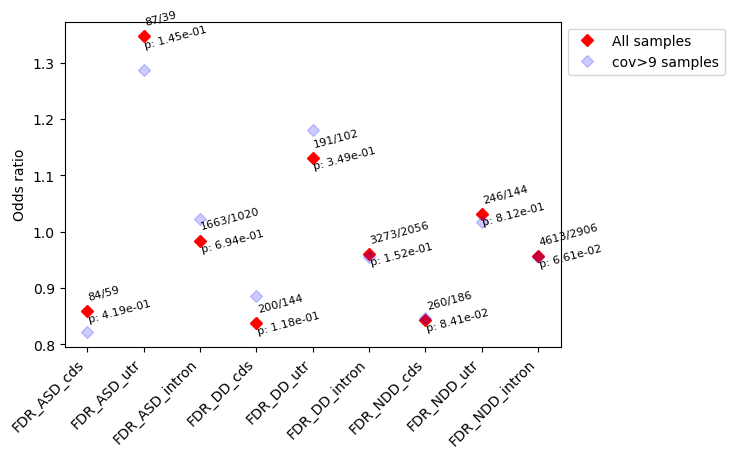

In [22]:
# plot enrichment in constrained subsets
fts = consts_subsec_2
fig_name = 'odds_ratio_fdr_subset.png'

ORs = []
text_info = []
chisq_ps = []
ORs_hc = []
text_info_hc = []
chisq_ps_hc = []
for ft in fts:
    df_w = df.loc[df[f'X_{ft}'] == 1]
    df_wo = df.loc[df[f'X_{ft}'] == 0]
    print(f'TR regions intersecting {ft}: {df_w.shape[0]}')
    
    n_w_ft_case = df_w['LZS_CASE_NUM'].sum()
    n_w_ft_control = df_w['LZS_CONTROL_NUM'].sum()
    n_wo_ft_case = df_wo['LZS_CASE_NUM'].sum()
    n_wo_ft_control = df_wo['LZS_CONTROL_NUM'].sum()
    text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
    
    OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
    #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')
    #print(f'OR: {OR}')
    ORs.append(OR)
    
    ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps.append(p_val)

    n_w_ft_case_hc = df_w['LZS_CASE_COV_NUM'].sum()
    n_w_ft_control_hc = df_w['LZS_CONTROL_COV_NUM'].sum()
    n_wo_ft_case_hc = df_wo['LZS_CASE_COV_NUM'].sum()
    n_wo_ft_control_hc = df_wo['LZS_CONTROL_COV_NUM'].sum()

    OR_hc = (n_w_ft_case_hc / n_w_ft_control_hc) / (n_wo_ft_case_hc / n_wo_ft_control_hc)
    ORs_hc.append(OR_hc)
    
    ob = np.array([[n_w_ft_case_hc, n_wo_ft_case_hc], [n_w_ft_control_hc, n_wo_ft_control_hc]])
    chi2_stat, p_val, dof, expected = chi2_contingency(ob)
    chisq_ps_hc.append(p_val)

	
print('case/control chi-squared p-values:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps]))

print()
print('case/control chi-squared p-values high coverage samples:')
print(' '.join(fts))
print(' '.join([f'{x:.2e}' for x in chisq_ps_hc]))

AR = 10
plt.figure()
plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
plt.plot(range(0,len(fts)), ORs_hc, 'Db', alpha=.2, label='cov>9 samples')
for i in range(0,len(fts)):
    plt.text(i, ORs[i]+.02, text_info[i], rotation=15, fontsize=8)
    plt.text(i, ORs[i]-.02, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
plt.gca().set_aspect(AR)
plt.ylabel('Odds ratio')
#plt.title('numbers: # cases / # controls, xing features')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()


In [23]:
def get_aff():
	meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
	df_meta = pd.read_table(meta_file, sep='\t', header=0)
	#print(df_meta)
	
	aff_dict = {}
	for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
		aff_dict[sample] = aff
	return aff_dict

In [24]:
aff_dict = get_aff()

In [25]:
def get_expanded_df(df_in):
    samples = []
    case_control_status = []
    zs = []
    gbs = []
    for row in df_in['LZS_SAMPLES'].tolist():
        if row == '.':
            continue
        for x in row.split(','):
            sample, z_str, gb_str = x.split(':')
            z_max = 0; gb_max = 0;
            for z, gb in zip(z_str.split('|'), gb_str.split('|')):
                if abs(float(z)) > abs(z_max):
                    z_max = float(z)
                if abs(int(gb)) > abs(gb_max):
                    gb_max = int(gb)
            samples.append(sample)
            zs.append(z_max)
            gbs.append(gb_max)
            if sample in aff_dict:
                case_control_status.append(aff_dict[sample])
            else:
                case_control_status.append('.')
                
    df_out = pd.DataFrame({'sample': samples, 'Z-score': zs, 'base-pair': gbs, 'status': case_control_status})
    return df_out

In [26]:
# expanding the dataframe for xing and not xing regions with col
col = 'X_protein_coding_cds'
this_df_x = df.loc[(df[col] == 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_x = get_expanded_df(this_df_x)

this_df_nx = df.loc[(df[col] != 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_nx = get_expanded_df(this_df_nx)

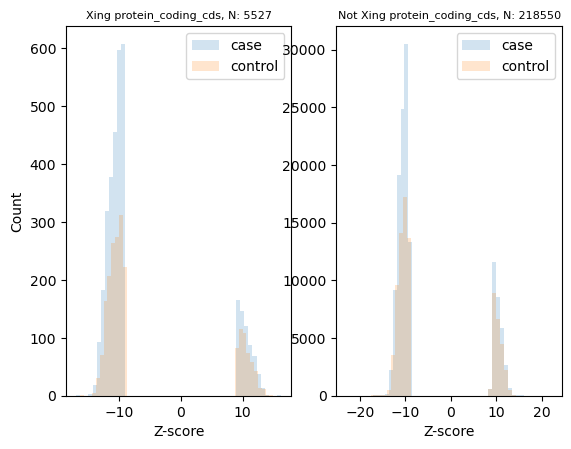

zscore_protein_coding_cds.png


In [27]:
feature = 'protein_coding_cds'
fig_name = f'zscore_{feature}.png'
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax1.set_xlabel('Z-score')
ax1.set_ylabel('Count')
ax1.set_title(f'Xing {feature}, N: {this_df_exp_x.shape[0]}', fontsize=8)
ax1.legend()
#fig_name = 'hist_notcds_lzs_zscore.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax2.set_xlabel('Z-score')
ax2.set_title(f'Not Xing {feature}, N: {this_df_exp_nx.shape[0]}', fontsize=8)
ax2.legend()
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
print(fig_name)
plt.close()

In [28]:
# expanding the dataframe for xing and not xing regions with col
col = 'X_PLI_cds'
this_df_x = df.loc[(df[col] == 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_x = get_expanded_df(this_df_x)

this_df_nx = df.loc[(df[col] != 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_nx = get_expanded_df(this_df_nx)

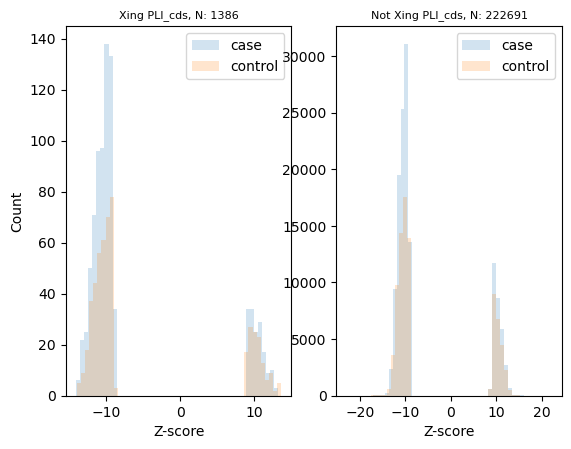

zscore_PLI_cds.png


In [29]:
feature = 'PLI_cds'
fig_name = f'zscore_{feature}.png'
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax1.set_xlabel('Z-score')
ax1.set_ylabel('Count')
ax1.set_title(f'Xing {feature}, N: {this_df_exp_x.shape[0]}', fontsize=8)
ax1.legend()
#fig_name = 'hist_notcds_lzs_zscore.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax2.set_xlabel('Z-score')
ax2.set_title(f'Not Xing {feature}, N: {this_df_exp_nx.shape[0]}', fontsize=8)
ax2.legend()
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
print(fig_name)
plt.close()

In [30]:
# expanding the dataframe for xing and not xing regions with col
col = 'X_GNOCCHI_4'
this_df_x = df.loc[(df[col] == 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_x = get_expanded_df(this_df_x)

this_df_nx = df.loc[(df[col] != 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_nx = get_expanded_df(this_df_nx)

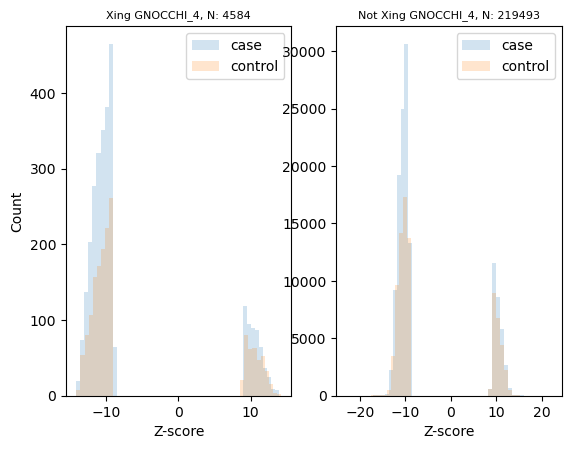

zscore_GNOCCHI_4.png


In [31]:
feature = 'GNOCCHI_4'
fig_name = f'zscore_{feature}.png'
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax1.set_xlabel('Z-score')
ax1.set_ylabel('Count')
ax1.set_title(f'Xing {feature}, N: {this_df_exp_x.shape[0]}', fontsize=8)
ax1.legend()
#fig_name = 'hist_notcds_lzs_zscore.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax2.set_xlabel('Z-score')
ax2.set_title(f'Not Xing {feature}, N: {this_df_exp_nx.shape[0]}', fontsize=8)
ax2.legend()
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
print(fig_name)
plt.close()

In [32]:
# expanding the dataframe for xing and not xing regions with col
col = 'X_FDR_ASD_utr'
this_df_x = df.loc[(df[col] == 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_x = get_expanded_df(this_df_x)

this_df_nx = df.loc[(df[col] != 1) & (df.LZS_SAMPLES_NUM > 0)]
this_df_exp_nx = get_expanded_df(this_df_nx)

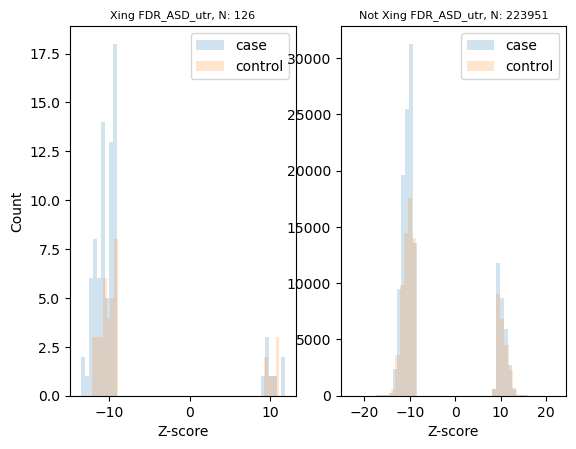

zscore_FDR_ASD_utr.png


In [33]:
feature = 'FDR_ASD_utr'
fig_name = f'zscore_{feature}.png'
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax1.hist(this_df_exp_x.loc[this_df_exp_x.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax1.set_xlabel('Z-score')
ax1.set_ylabel('Count')
ax1.set_title(f'Xing {feature}, N: {this_df_exp_x.shape[0]}', fontsize=8)
ax1.legend()
#fig_name = 'hist_notcds_lzs_zscore.png'
#print(fig_name)
#plt.savefig(fig_name, bbox_inches='tight')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'Yes']['Z-score'], bins=50, alpha=0.2, label='case')
ax2.hist(this_df_exp_nx.loc[this_df_exp_nx.status == 'No']['Z-score'], bins=50, alpha=0.2, label='control')
ax2.set_xlabel('Z-score')
ax2.set_title(f'Not Xing {feature}, N: {this_df_exp_nx.shape[0]}', fontsize=8)
ax2.legend()
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
print(fig_name)
plt.close()